# Netzwerkanalyse

Dieses Notebook führt eine umfassende Analyse des Modulnetzwerks durch.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import community as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations, chain
import warnings
import scipy
warnings.filterwarnings('ignore')

# Setze Style für bessere Visualisierungen
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 1. Datenladen und Netzwerkaufbau


In [4]:
# Daten laden - kombiniere alle Edge-Dateien
edges_pre_req = pd.read_csv('../data/edges_pre_req.csv')
edges_same_group = pd.read_csv('../data/edges_same_group.csv')
edges_same_semester = pd.read_csv('../data/edges_same_semester.csv')

# Kombiniere alle Edge-Dateien
edges = pd.concat([edges_pre_req, edges_same_group, edges_same_semester], ignore_index=True)

nodes = pd.read_csv('../data/nodes.csv')

# Netzwerk aufbauen
# Beachte: edges_pre_req sind gerichtet, edges_same_group und edges_same_semester sind ungerichtet
# Wir erstellen einen gerichteten Graph - ungerichtete Kanten werden als bidirektional behandelt
G = nx.from_pandas_edgelist(edges, 'Source', 'Target', 
                           edge_attr=['Type', 'Label'], create_using=nx.DiGraph())

# Knotenattribute hinzufügen
nx.set_node_attributes(G, nodes.set_index('Id')['Gruppe'].to_dict(), 'Gruppe')
nx.set_node_attributes(G, nodes.set_index('Id')['Semester'].to_dict(), 'Semester')
nx.set_node_attributes(G, nodes.set_index('Id')['Name'].to_dict(), 'Name')

# Ungerichtete Version für bestimmte Analysen
G_undir = G.to_undirected()

print(f"Netzwerk: {G.number_of_nodes()} Knoten, {G.number_of_edges()} Kanten")
print(f"Gerichtet: {nx.is_directed(G)}")
print(f"Zyklisch: {not nx.is_directed_acyclic_graph(G)}")

# Anzahl Kanten pro Edge-Typ (kombiniert)
print("Anzahl Kanten pro Edge-Typ (kombiniert):")
print(edges['Type'].value_counts().to_string())

print(f"  Pre-Req: {len(edges_pre_req)}")
print(f"  Same Group: {len(edges_same_group)}")
print(f"  Same Semester: {len(edges_same_semester)}")


Netzwerk: 87 Knoten, 1081 Kanten
Gerichtet: True
Zyklisch: False
Anzahl Kanten pro Edge-Typ (kombiniert):
Type
Undirected    1312
Directed        10
  Pre-Req: 10
  Same Group: 544
  Same Semester: 768


## 2. Grundlegende Netzwerkmetriken


In [3]:
print("=== Grundlegende Netzwerkmetriken ===")
print(f"Dichte: {nx.density(G):.4f}")
print(f"Durchschnittlicher Grad: {2*G.number_of_edges()/G.number_of_nodes():.2f}")

# Connected Components
scc = list(nx.strongly_connected_components(G))
wcc = list(nx.weakly_connected_components(G))
print(f"Strongly Connected Components: {len(scc)}")
print(f"Weakly Connected Components: {len(wcc)}")

if len(scc) > 0:
    largest_scc = max(scc, key=len)
    G_scc = G.subgraph(largest_scc).copy()
    if len(largest_scc) > 1:
        print(f"Diameter grösster SCC: {nx.diameter(G_scc)}")
        print(f"Radius grösster SCC: {nx.radius(G_scc)}")
    else:
        print("Grösster SCC hat nur 1 Knoten")

# Clustering
print(f"Average Clustering (ungerichtet): {nx.average_clustering(G_undir):.4f}")

# Transitivität
print(f"Transitivität: {nx.transitivity(G_undir):.4f}")


=== Grundlegende Netzwerkmetriken ===
Dichte: 0.1445
Durchschnittlicher Grad: 24.85
Strongly Connected Components: 87
Weakly Connected Components: 1
Grösster SCC hat nur 1 Knoten
Average Clustering (ungerichtet): 0.6837
Transitivität: 0.7121


### Interpretation der grundlegenden Netzwerkmetriken

**Hinweis:** Diese Metriken beziehen sich auf das **kombinierte Netzwerk**, das alle Edge-Typen enthält: Voraussetzungen (gerichtete Kanten), Same Group (ungerichtete Kanten) und Same Semester (ungerichtete Kanten). Die Kombination aller Edge-Typen führt zu einer deutlich höheren Vernetzung als ein reines Voraussetzungsnetzwerk.

**Dichte:**
- Die Dichte misst das Verhältnis von tatsächlichen zu möglichen Verbindungen im Netzwerk.
- **Hinweis:** Da Module derselben Gruppe und desselben Semesters vollständig miteinander verbunden sind (Cliquen-Struktur), ist die Dichte deutlich höher als bei einem reinen Voraussetzungsnetzwerk. Dies spiegelt die starke interne Vernetzung innerhalb von Gruppen und Semestern wider.

**Durchschnittlicher Grad:**
- Der durchschnittliche Grad gibt an, wie viele Verbindungen jedes Modul im Durchschnitt hat.
- **Hinweis:** Durch die Kombination aller Edge-Typen hat jedes Modul deutlich mehr Verbindungen als bei einem reinen Voraussetzungsnetzwerk. Module derselben Gruppe oder desselben Semesters sind vollständig miteinander verbunden, was zu hohen Graden führt.

**Connected Components:**
- Connected Components sind getrennte Teilnetzwerke, zwischen denen keine Verbindungen existieren.
- **Hinweis:** Durch die ungerichteten Kanten (Same Group, Same Semester) ist das Netzwerk stark verbunden. Module derselben Gruppe und desselben Semesters sind verbunden, sodass die meisten Module in einer grossen Komponente liegen. Isolierte Module sind selten.

**Clustering & Transitivität:**
- Clustering misst die Wahrscheinlichkeit, dass benachbarte Knoten auch untereinander verbunden sind.
- **Hinweis:** Durch die Cliquen-Struktur von Same Group und Same Semester Kanten haben Clustering und Transitivität typischerweise Werte grösser 0. Module derselben Gruppe/Semesters bilden vollständig verbundene Cliquen, was zu hohen Clustering-Werten führt.


## 3. Zentralitätsmasse


In [4]:
print("=== Zentralitätsmasse ===")

# Verschiedene Zentralitätsmasse berechnen
centralities = {
    'InDegree': nx.in_degree_centrality(G),
    'OutDegree': nx.out_degree_centrality(G),
    'Closeness': nx.closeness_centrality(G),
    'Betweenness': nx.betweenness_centrality(G),
    'Eigenvector': nx.eigenvector_centrality(G, max_iter=1000),
    'PageRank': nx.pagerank(G),
    'Katz': nx.katz_centrality(G, max_iter=1000)
}

cent_df = pd.DataFrame(centralities).round(4)

print("\nTop 5 nach Betweenness (Brückenmodule):")
print(cent_df.sort_values('Betweenness', ascending=False).head())

print("\nTop 5 nach InDegree (beliebte Voraussetzungen):")
print(cent_df.sort_values('InDegree', ascending=False).head())

print("\nTop 5 nach OutDegree (Module mit vielen Voraussetzungen):")
print(cent_df.sort_values('OutDegree', ascending=False).head())


=== Zentralitätsmasse ===

Top 5 nach Betweenness (Brückenmodule):
       InDegree  OutDegree  Closeness  Betweenness  Eigenvector  PageRank  \
enwi     0.1395     0.3488     0.1917       0.0264          0.0    0.0056   
pro4M    0.1395     0.0465     0.3126       0.0233          0.0    0.0150   
pro3M    0.1977     0.0581     0.3779       0.0228          0.0    0.0136   
dan      0.0698     0.2674     0.0879       0.0159          0.0    0.0043   
pro5M    0.3488     0.0698     0.5072       0.0140          0.0    0.0204   

         Katz  
enwi   0.0425  
pro4M  0.0501  
pro3M  0.1063  
dan    0.0248  
pro5M  0.2179  

Top 5 nach InDegree (beliebte Voraussetzungen):
       InDegree  OutDegree  Closeness  Betweenness  Eigenvector  PageRank  \
waem     0.4419     0.0116     0.5012       0.0002       0.0530    0.0724   
wueb     0.4419     0.0000     0.5293       0.0000       0.9986    0.1289   
veva     0.4186     0.0349     0.4767       0.0005       0.0001    0.0295   
thd3     0.3837  

### Interpretation der Zentralitätsmasse

**Hinweis:** Diese Zentralitätsmasse werden auf dem **kombinierten Netzwerk** (alle Edge-Typen) berechnet. Die Werte werden daher durch alle Verbindungstypen beeinflusst, nicht nur durch Voraussetzungen.

**Betweenness Centrality - Brückenmodule:**
- Betweenness misst, wie oft ein Modul auf den kürzesten Pfaden zwischen anderen Modulen liegt.
- Module mit hoher Betweenness sind kritische "Engpässe" oder "Brücken" im Netzwerk - viele Pfade führen durch sie hindurch.
- **Typische Eigenschaften:** Oft Module in der Mitte der Voraussetzungshierarchie, die verschiedene Bereiche des Curriculums verbinden.
- **Praktische Bedeutung:** Wenn Studenten diese Module nicht bestehen, kann dies den Fortschritt zu vielen nachfolgenden Modulen blockieren. Diese Module sollten besonders unterstützt werden (z.B. zusätzliche Tutorien, flexible Prüfungstermine).

**In-Degree Centrality - Module mit vielen eingehenden Verbindungen:**
- In-Degree misst die Anzahl eingehender Verbindungen (Voraussetzungen und Same Group/Semester).
- Module mit hohem In-Degree haben viele Module, die auf sie aufbauen oder mit ihnen verbunden sind.
- **Typische Eigenschaften:** Oft Module auf höheren Ebenen der Voraussetzungshierarchie oder Module in grossen Gruppen/Semestern.
- **Bedeutung:** Diese Module sind fundamentale Bausteine des Curriculums. Studenten sollten diese Module frühzeitig und erfolgreich abschliessen.

**Out-Degree Centrality - Module mit vielen ausgehenden Verbindungen:**
- Out-Degree misst die Anzahl ausgehender Verbindungen (Voraussetzungen und Same Group/Semester).
- Module mit hohem Out-Degree sind Voraussetzung für viele andere Module oder gehören zu grossen Gruppen/Semestern.
- **Typische Eigenschaften:** Oft Module auf niedrigeren Ebenen der Voraussetzungshierarchie oder Module in grossen Gruppen/Semestern.

**PageRank & Katz Centrality - Rekursive Zentralitätsmasse:**
- PageRank und Katz berücksichtigen nicht nur direkte Verbindungen, sondern auch die Zentralität verbundener Module.
- Module mit hohem PageRank sind nicht nur zentral, sondern auch mit anderen zentralen Modulen verbunden.
- **Typische Eigenschaften:** Oft Module in der Projektsequenz oder Module, die zentrale Positionen in der Voraussetzungshierarchie einnehmen.
- **Bedeutung:** Diese Module sind strategisch wichtig - sie verbinden verschiedene Bereiche des Curriculums und sind für die Gesamtstruktur des Netzwerks entscheidend.


## 4. Pfadanalyse - Kritische Wege im Netzwerk


In [5]:
print("=== Pfadanalyse ===")

# Finde alle kürzesten Pfade zwischen Knoten
all_pairs_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

# Finde längste Pfade (kritische Pfade)
def find_longest_paths(G):
    """Finde die längsten Pfade im DAG"""
    longest_paths = []
    max_length = 0
    
    # Finde Quellen (Knoten ohne eingehende Kanten)
    sources = [n for n in G.nodes() if G.in_degree(n) == 0]
    # Finde Senken (Knoten ohne ausgehende Kanten)
    sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
    
    for source in sources:
        for sink in sinks:
            if nx.has_path(G, source, sink):
                path = nx.shortest_path(G, source, sink)
                length = len(path) - 1
                if length > max_length:
                    max_length = length
                    longest_paths = [path]
                elif length == max_length:
                    longest_paths.append(path)
    
    return longest_paths, max_length

longest_paths, max_path_length = find_longest_paths(G)
print(f"Längster Pfad: {max_path_length} Schritte")
print(f"Anzahl längster Pfade: {len(longest_paths)}")
if longest_paths:
    print(f"Beispiel längster Pfad: {' -> '.join(longest_paths[0])}")

# Durchschnittliche Pfadlänge
path_lengths = []
for source in G.nodes():
    for target in G.nodes():
        if source != target and nx.has_path(G, source, target):
            path_lengths.append(nx.shortest_path_length(G, source, target))

if path_lengths:
    print(f"Durchschnittliche Pfadlänge: {np.mean(path_lengths):.2f}")
    print(f"Maximale Pfadlänge: {max(path_lengths)}")


=== Pfadanalyse ===
Längster Pfad: 4 Schritte
Anzahl längster Pfade: 1
Beispiel längster Pfad: aem -> eeww -> enwi -> phwkL -> wkwkL
Durchschnittliche Pfadlänge: 2.03
Maximale Pfadlänge: 7


### Interpretation der Pfadanalyse

**Hinweis:** Die Pfadanalyse betrachtet nur die **gerichteten Voraussetzungen** im kombinierten Netzwerk. Obwohl Module auch über ungerichtete Verbindungen (Same Group, Same Semester) erreichbar sind, basieren die Pfadlängen nur auf den Voraussetzungsbeziehungen, da diese die zeitliche Abfolge bestimmen.

**Längster Pfad - Der kritische Pfad:**
- Der längste Pfad zwischen einer Quelle (Modul ohne Voraussetzungen) und einer Senke (Modul ohne nachfolgende Module) zeigt den kritischsten Weg durch das Curriculum.
- **Bedeutung:** Dies ist der **kritische Pfad** des Studiums - er definiert die minimale Zeit bis zum Abschluss. Jedes Modul auf diesem Pfad muss erfolgreich abgeschlossen werden, bevor die nachfolgenden Module belegt werden können.
- **Typische Struktur:** Die Projektsequenz (pro1M → pro2M → ... → pro6M) bildet oft einen wichtigen Teil des kritischen Pfads, da diese Module sequenziell aufeinander aufbauen.

**Durchschnittliche Pfadlänge:**
- Die durchschnittliche Pfadlänge misst, wie viele Voraussetzungsschritte im Durchschnitt zwischen zwei beliebigen Modulen liegen.
- **Interpretation:** Ein niedriger Wert zeigt eine kompakte Voraussetzungsstruktur, ein hoher Wert zeigt eine tiefe Hierarchie. Die Werte geben Aufschluss über die Komplexität der Voraussetzungsstruktur.
- **Typische Werte:** Die Pfadlängen zeigen, ob Module eher isoliert sind oder stark in die Voraussetzungsstruktur eingebunden sind.

**Bedeutung für die Studienplanung:**
- **Kritische Pfade** müssen von Studenten in der richtigen Reihenfolge durchlaufen werden - keine Parallelisierung möglich.
- Ein Ausfall oder eine Verzögerung in einem Modul auf dem kritischen Pfad kann alle nachfolgenden Module verzögern.
- **Empfehlungen:**
  - Kritische Pfade sollten besonders unterstützt werden (z.B. zusätzliche Tutorien, flexible Prüfungstermine).
  - Frühwarnsysteme für Studenten, die Probleme in kritischen Modulen haben.
  - Alternative Wege oder Ausweichmöglichkeiten sollten geprüft werden, um die Flexibilität zu erhöhen.


## 5. Hierarchieanalyse - DAG-Struktur und Ebenen


In [6]:
print("=== Hierarchieanalyse ===")

# Prüfe ob DAG
is_dag = nx.is_directed_acyclic_graph(G)
print(f"Ist DAG: {is_dag}")

if is_dag:
    # Topologische Sortierung
    topo_order = list(nx.topological_sort(G))
    print(f"\nTopologische Sortierung (erste 10): {topo_order[:10]}")
    
    # Ebenen im DAG (wie viele Schritte von der Quelle entfernt)
    def calculate_levels(G):
        levels = {}
        # Quellen sind Level 0
        for node in G.nodes():
            if G.in_degree(node) == 0:
                levels[node] = 0
        
        # BFS um Level zu berechnen
        queue = [n for n in G.nodes() if G.in_degree(n) == 0]
        while queue:
            node = queue.pop(0)
            for neighbor in G.successors(node):
                if neighbor not in levels:
                    levels[neighbor] = levels[node] + 1
                    queue.append(neighbor)
                else:
                    levels[neighbor] = max(levels[neighbor], levels[node] + 1)
        
        return levels
    
    levels = calculate_levels(G)
    level_df = pd.DataFrame(list(levels.items()), columns=['Modul', 'Level'])
    print(f"\nEbenenverteilung:\n {level_df['Level'].value_counts().sort_index()}")
    
    # Module pro Ebene
    print(f"\nModule pro Ebene:")
    for level in sorted(set(levels.values())):
        modules = [m for m, l in levels.items() if l == level]
        print(f"  Ebene {level}: {modules}")
else:
    # Finde Zyklen
    cycles = list(nx.simple_cycles(G))
    print(f"\nAnzahl Zyklen: {len(cycles)}")
    if cycles:
        print(f"Beispiel Zyklen (erste 3):")
        for i, cycle in enumerate(cycles[:3]):
            print(f"  Zyklus {i+1}: {' -> '.join(cycle)} -> {cycle[0]}")


=== Hierarchieanalyse ===
Ist DAG: True

Topologische Sortierung (erste 10): ['afems', 'aem', 'atL', 'an1', 'am', 'cfds', 'an2', 'ch1', 'amat', 'dms']

Ebenenverteilung:
 Level
0     4
1     4
2     7
3     3
4     4
5     2
6     8
7     5
8     5
9     4
10    5
11    3
12    5
13    4
14    1
15    1
16    2
17    1
18    1
19    1
20    1
21    2
22    6
23    6
24    1
25    1
Name: count, dtype: int64

Module pro Ebene:
  Ebene 0: ['afems', 'aem', 'atL', 'an1']
  Ebene 1: ['am', 'cfds', 'an2', 'ch1']
  Ebene 2: ['amp', 'asimv', 'amat', 'apd', 'dms', 'hkon', 'chkL']
  Ebene 3: ['c2ad', 'c1d', 'egts']
  Ebene 4: ['cich', 'c1m', 'mst', 'fems']
  Ebene 5: ['dan', 'dglM']
  Ebene 6: ['dsf', 'eeww', 'dpev2', 'dpev1', 'man', 'num', 'infM', 'elmag']
  Ebene 7: ['ekt', 'lalg1', 'mechM', 'elstk', 'lalg2']
  Ebene 8: ['enwi', 'eltM', 'sww', 'pro1M', 'mel']
  Ebene 9: ['fkte', 'werk1', 'flmM', 'pro2M']
  Ebene 10: ['idacu', 'flm3', 'md', 'kmk', 'stk']
  Ebene 11: ['flm4', 'kt1', 'thdM']
  Eb

### Interpretation der Hierarchieanalyse

**Hinweis:** Die Hierarchieanalyse betrachtet nur die **gerichteten Voraussetzungen** im kombinierten Netzwerk. Die Voraussetzungshierarchie bestimmt die zeitliche Abfolge der Module, auch wenn das Gesamtnetzwerk durch Same Group und Same Semester Kanten stärker verbunden ist.

**DAG-Struktur (Directed Acyclic Graph):**
- Das Voraussetzungsnetzwerk ist ein DAG - es enthält keine Zyklen, d.h. kein Modul kann direkt oder indirekt Voraussetzung für sich selbst sein.
- **Bedeutung:** Dies ist **essentiell** für einen funktionierenden Studienplan. Zyklen würden bedeuten, dass Module gegenseitig Voraussetzungen voneinander sind, was logisch unmöglich ist.
- Die DAG-Struktur ermöglicht eine eindeutige Hierarchisierung der Module nach Voraussetzungsebenen.

**Ebenenverteilung:**
- **Ebene 0 (Quellen):** Module ohne eingehende Voraussetzungen. Studenten können diese sofort zu Beginn des Studiums belegen.
- **Höhere Ebenen:** Module auf höheren Ebenen haben Voraussetzungen auf niedrigeren Ebenen und können erst nach erfolgreichem Abschluss dieser belegt werden.
- **Interpretation:** Die Anzahl der Ebenen zeigt die Tiefe der Voraussetzungshierarchie. Eine flache Hierarchie (wenige Ebenen) bietet mehr Flexibilität, eine tiefe Hierarchie (viele Ebenen) zeigt eine starke sequenzielle Struktur.

**Topologische Sortierung:**
- Die topologische Sortierung zeigt eine mögliche Belegungsreihenfolge, die alle Voraussetzungen respektiert.
- **Bedeutung:** Module können in dieser Reihenfolge belegt werden, ohne Voraussetzungen zu verletzen. Module auf derselben Ebene können theoretisch parallel belegt werden.

**Praktische Implikationen:**
- **Flexibilität:** Module auf Ebene 0 bieten Studenten Flexibilität in der Belegung - verschiedene Startpunkte sind möglich.
- **Planbarkeit:** Die klare Hierarchie erleichtert die Studienplanung - Studenten wissen, welche Module sie zuerst abschliessen müssen.
- **Sequenzielle Strukturen:** Die Projektsequenz (pro1M → pro2M → ... → pro6M) ist typischerweise linear und sequenziell über mehrere Ebenen verteilt - keine Parallelisierung möglich.
- **Empfehlung:** Module der gleichen Ebene können parallel belegt werden, was die Studienplanung flexibler macht und ermöglicht, das Studium zu beschleunigen.


## 6. Erreichbarkeitsanalyse - Wer kann wen erreichen?


In [7]:
print("=== Erreichbarkeitsanalyse ===")

# Erreichbarkeitsmatrix
reachability_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
reachability = nx.transitive_closure(G)

# Anzahl erreichbarer Knoten von jedem Knoten
reachable_counts = {}
for node in G.nodes():
    reachable = set()
    for target in G.nodes():
        if nx.has_path(G, node, target):
            reachable.add(target)
    reachable_counts[node] = len(reachable) - 1  # -1 für sich selbst

reachable_df = pd.DataFrame(list(reachable_counts.items()), 
                           columns=['Modul', 'Erreichbare_Module'])
reachable_df = reachable_df.sort_values('Erreichbare_Module', ascending=False)

print("Top 5 Module mit meisten erreichbaren Modulen:")
print(reachable_df.head())

# Module, die von vielen anderen erreicht werden können
reachable_from_counts = {}
for node in G.nodes():
    count = sum(1 for source in G.nodes() 
                if source != node and nx.has_path(G, source, node))
    reachable_from_counts[node] = count

reachable_from_df = pd.DataFrame(list(reachable_from_counts.items()),
                                columns=['Modul', 'Erreichbar_von'])
reachable_from_df = reachable_from_df.sort_values('Erreichbar_von', ascending=False)

print("\nTop 5 Module, die von den meisten anderen Modulen erreicht werden:")
print(reachable_from_df.head())


=== Erreichbarkeitsanalyse ===
Top 5 Module mit meisten erreichbaren Modulen:
    Modul  Erreichbare_Module
36    aem                  75
37     am                  74
11  afems                  74
38   amat                  73
12    amp                  69

Top 5 Module, die von den meisten anderen Modulen erreicht werden:
    Modul  Erreichbar_von
53   wueb              84
35   waem              76
34    vmo              75
66  wkwkL              74
71    wst              74


### Interpretation der Erreichbarkeitsanalyse

**Hinweis:** Die Erreichbarkeitsanalyse betrachtet nur die **gerichteten Voraussetzungen** im kombinierten Netzwerk. Obwohl Module auch über ungerichtete Verbindungen erreichbar sind, basiert die Erreichbarkeit hier auf den Voraussetzungsbeziehungen, da diese die logische Abfolge bestimmen.

**Module mit meisten erreichbaren Modulen (Quellen):**
- Diese Module können über Voraussetzungspfade viele andere Module erreichen.
- **Typische Eigenschaften:** Module auf niedrigen Ebenen (Ebene 0 oder 1), die keine oder wenige Voraussetzungen haben - sogenannte "Quellen".
- **Bedeutung:** Diese Module sind Startpunkte für längere Pfade durch das Curriculum. Studenten können von diesen Modulen aus viele verschiedene Wege durch das Studium nehmen.

**Module, die von den meisten erreicht werden (Senken):**
- Diese Module werden über Voraussetzungspfade von vielen anderen Modulen erreicht.
- **Typische Eigenschaften:** Module auf hohen Ebenen der Voraussetzungshierarchie, oft Endpunkte wie die Bachelor Thesis (z.B. pro6M).
- **Bedeutung:** Diese Module sind wichtige Ziele im Curriculum. Viele Grundlagenmodule sind Voraussetzung dafür. Späte Projektmodule (z.B. pro4M, pro5M, pro6M) werden typischerweise von vielen Modulen erreicht.

**Strukturelle Bedeutung:**
- Die Projektsequenz bildet typischerweise das **"Rückgrat"** des Curriculums - viele Module führen letztendlich zu den Projektmodulen.
- Module auf hohen Ebenen sind kritische Ziele - Verzögerungen oder Probleme in Voraussetzungen wirken sich hier besonders aus.
- Dies zeigt, dass die Projektmodule gut in das Curriculum integriert sind und eine zentrale Rolle spielen.

**Praktische Konsequenzen:**
- Studenten, die Probleme mit Grundlagenmodulen (auf niedrigen Ebenen) haben, werden diese Schwierigkeiten bis zu den späteren Modulen (insbesondere der Bachelor Thesis) mit sich tragen.
- **Empfehlung:** Frühzeitige Unterstützung in Grundlagenmodulen ist besonders wichtig, da Probleme hier langfristige Auswirkungen haben.
- Die Analyse hilft dabei, kritische Module zu identifizieren, die viele Studenten erreichen müssen.


## 7. Community Detection - Gruppierung von Modulen


In [8]:
print("=== Community Detection ===")

# Louvain Algorithmus
partition = community_louvain.best_partition(G_undir)
modularity = community_louvain.modularity(partition, G_undir)
print(f"Louvain Modularity: {modularity:.4f}")
print(f"Anzahl Communities: {len(set(partition.values()))}")

# Community-Zuordnung
comm_df = pd.DataFrame(list(partition.items()), columns=['Modul', 'Community'])
comm_df = comm_df.merge(nodes[['Id', 'Gruppe', 'Name']], 
                       left_on='Modul', right_on='Id', how='left')
print("\nCommunities nach Grösse:")
print(comm_df.groupby('Community').size().sort_values(ascending=False))

# Zeige Module pro Community
print("\nModule pro Community:")
for comm in sorted(set(partition.values())):
    modules = comm_df[comm_df['Community'] == comm]['Modul'].tolist()
    print(f"  Community {comm}: {modules}")

# Vergleich mit tatsächlichen Gruppen
print("\nCommunity vs. tatsächliche Gruppen:")
comm_group_cross = pd.crosstab(comm_df['Community'], comm_df['Gruppe'])
print(comm_group_cross)


=== Community Detection ===
Louvain Modularity: 0.3725
Anzahl Communities: 4

Communities nach Grösse:
Community
0    30
1    25
2    17
3    15
dtype: int64

Module pro Community:
  Community 0: ['pro1M', 'pro2M', 'stk', 'pro4M', 'fems', 'cfds', 'ch1', 'mechM', 'sww', 'wch', 'wus', 'atL', 'chkL', 'mst', 'wkwkL', 'infM', 'lalg1', 'lalg2', 'an1', 'an2', 'man', 'num', 'dms', 'md', 'egts', 'thdM', 'hkon', 'mel', 'werk1', 'werk2']
  Community 1: ['pro5M', 'eeww', 'ekt', 'fkte', 'labvM', 'matl', 'meas1', 'minat', 'naku', 'veva', 'waem', 'aem', 'am', 'apd', 'c1d', 'c1m', 'dpev1', 'flm3', 'kt1', 'mant1', 'mea', 'thd3', 'wueb', 'rtL', 'dan']
  Community 2: ['pro3M', 'elstk', 'kmk', 'cich', 'dsf', 'enwi', 'mata', 'mimo', 'mlam', 'npe', 'elmag', 'eltM', 'phwkL', 'wst', 'dglM', 'flmM', 'werk3']
  Community 3: ['pro6M', 'afems', 'amp', 'asimv', 'c2ad', 'idacu', 'mantL', 'tamp', 'vmo', 'amat', 'dpev2', 'flm4', 'kt2', 'mant2', 'thd4']

Community vs. tatsächliche Gruppen:
Gruppe     Fachergänzung: Ma

### Interpretation der Community Detection

**Hinweis:** Die Community Detection verwendet das **ungerichtete Netzwerk** (alle Edge-Typen kombiniert). Da Module derselben Gruppe und desselben Semesters vollständig miteinander verbunden sind (Cliquen-Struktur), bilden diese typischerweise dichte, gut definierte Communities.

**Modularity - Mass für Community-Qualität:**
- Modularity misst, wie gut das Netzwerk in Communities aufgeteilt werden kann. Werte nahe 0 bedeuten keine klare Community-Struktur (zufällig), positive Werte zeigen eine strukturelle Organisation.
- **Typische Werte:** Ein Wert zwischen 0.3-0.5 zeigt eine moderate bis gute Community-Struktur. Das Netzwerk ist nicht zufällig, sondern hat klare Gruppierungen.
- **Interpretation:** Höhere Modularity-Werte deuten darauf hin, dass Module stärker innerhalb von Communities als zwischen Communities verbunden sind.

**Anzahl und Struktur der Communities:**
- Die Anzahl der gefundenen Communities hängt von der Netzwerkstruktur ab.
- **Einflussfaktoren:** Durch die Kombination aller Edge-Typen (Voraussetzungen, Same Group, Same Semester) werden Communities sowohl durch administrative Gruppen als auch durch Semesterzugehörigkeit beeinflusst.
- Module derselben Gruppe und desselben Semesters bilden typischerweise dichte Communities aufgrund der vollständigen Verbindungen (Cliquen-Struktur).

**Vergleich mit administrativen Gruppen:**
- Die gefundenen Communities entsprechen **teilweise** den administrativen Gruppen, aber nicht vollständig.
- **Gründe für Abweichungen:**
  - Module derselben Gruppe werden oft in derselben Community gefunden (Same Group Kanten).
  - Module desselben Semesters können auch Communities bilden (Same Semester Kanten).
  - Voraussetzungsbeziehungen können Communities über Gruppen- und Semestergrenzen hinweg schaffen.
- **Bedeutung:** Die **funktionale Struktur** (basierend auf allen Verbindungstypen) kann von der **administrativen Struktur** (nur Gruppenzuordnung) abweichen. Dies zeigt, wie Module tatsächlich im Netzwerk verbunden sind, nicht nur, wie sie administrativ kategorisiert sind.

**Praktische Anwendung:**
- Die Community-Struktur kann helfen, zusammengehörige Module zu identifizieren, die möglicherweise gemeinsam geplant oder koordiniert werden sollten.
- Communities können auch Hinweise auf interdisziplinäre Verbindungen geben, die über administrative Grenzen hinweggehen.


## 8. Robustheitsanalyse - Was passiert bei Ausfällen?


In [9]:
print("=== Robustheitsanalyse ===")

def analyze_removal_impact(G, nodes_to_remove, metric='connected_components'):
    """Analysiere Auswirkung von Knotenentfernung"""
    G_copy = G.copy()
    G_copy.remove_nodes_from(nodes_to_remove)
    
    if metric == 'connected_components':
        return len(list(nx.weakly_connected_components(G_copy)))
    elif metric == 'nodes_remaining':
        return G_copy.number_of_nodes()
    elif metric == 'edges_remaining':
        return G_copy.number_of_edges()
    return None

# Teste Entfernung jedes einzelnen Knotens
removal_impacts = []
for node in G.nodes():
    impact = analyze_removal_impact(G, [node], 'connected_components')
    original_components = len(list(nx.weakly_connected_components(G)))
    removal_impacts.append({
        'Modul': node,
        'Komponenten_nach_Entfernung': impact,
        'Differenz': impact - original_components
    })

removal_df = pd.DataFrame(removal_impacts)
removal_df = removal_df.sort_values('Differenz', ascending=False)

print("Top 5 kritischste Module (Entfernung führt zu mehr Komponenten):")
print(removal_df.head())

# Simuliere Entfernung mehrerer Knoten gleichzeitig
print("\n=== Simulation: Entfernung der Top-3 Betweenness Module ===")
top_betweenness = cent_df.sort_values('Betweenness', ascending=False).head(3).index.tolist()
print(f"Entfernte Module: {top_betweenness}")
G_removed = G.copy()
G_removed.remove_nodes_from(top_betweenness)
print(f"Verbleibende Knoten: {G_removed.number_of_nodes()}")
print(f"Verbleibende Kanten: {G_removed.number_of_edges()}")
print(f"Neue Komponenten: {len(list(nx.weakly_connected_components(G_removed)))}")


=== Robustheitsanalyse ===
Top 5 kritischste Module (Entfernung führt zu mehr Komponenten):
    Modul  Komponenten_nach_Entfernung  Differenz
0   pro1M                            1          0
55  elmag                            1          0
63   chkL                            1          0
62    rtL                            1          0
61   eltM                            1          0

=== Simulation: Entfernung der Top-3 Betweenness Module ===
Entfernte Module: ['enwi', 'pro4M', 'pro3M']
Verbleibende Knoten: 84
Verbleibende Kanten: 1003
Neue Komponenten: 1


### Interpretation der Robustheitsanalyse

**Hinweis:** Die Robustheitsanalyse betrachtet das **vollständige Netzwerk** (alle Edge-Typen kombiniert). Durch die ungerichteten Kanten (Same Group, Same Semester) ist das Netzwerk stärker verbunden als ein reines Voraussetzungsnetzwerk, was die Robustheit erhöht.

**Kritischste Module - Single Points of Failure:**
- Module mit hohem Betweenness (Brückenmodul-Funktion) sind besonders kritisch, da sie verschiedene Bereiche des Netzwerks verbinden.
- **Auswirkung der Entfernung:** Die Entfernung kritischer Module kann das Netzwerk in mehr Komponenten aufteilen, was bedeutet, dass Studenten nicht mehr von bestimmten Modulen zu anderen gelangen können.
- **Bedeutung:** Diese Module sind **Single Points of Failure** - ihr Ausfall hat grosse Auswirkungen auf die Gesamtstruktur des Curriculums.

**Simulation - Entfernung der Top-Betweenness Module:**
- Bei Entfernung der Module mit höchstem Betweenness entstehen mehr getrennte Komponenten.
- Die verbleibenden Verbindungen hängen von der Netzwerkstruktur ab - durch Same Group und Same Semester Kanten bleiben mehr Verbindungen erhalten als bei einem reinen Voraussetzungsnetzwerk.
- **Interpretation:** Module mit hohem Betweenness sind besonders wichtig für die Netzwerk-Konnektivität und sollten besonders geschützt werden.

**Praktische Bedeutung für die Studienplanung:**
- Kritische Module (hohes Betweenness) sind kritische Engpässe im Studienplan.
- **Risiko:** Wenn diese Module nicht angeboten werden, ausfallen (z.B. durch Dozentenausfall) oder nicht bestanden werden können, ist der Studienplan massiv gestört.
- **Empfehlungen für Robustheit:**
  - **Redundanz:** Mehrere Dozenten, die das Modul unterrichten können.
  - **Mehrfachangebot:** Mehrere Prüfungstermine pro Semester.
  - **Alternative Wege:** Überlegung, ob alternative Voraussetzungsstrukturen möglich sind.
  - **Frühwarnsysteme:** Monitoring von Studenten, die in diesen Modulen Probleme haben.
  - **Notfallplanung:** Strategien für den Fall, dass Module nicht angeboten werden können.

**Risikomanagement:**
- Die Abhängigkeit von kritischen Modulen macht das Curriculum anfällig für Störungen.
- **Robustheit:** Durch die Kombination aller Edge-Typen ist das Netzwerk robuster als bei einem reinen Voraussetzungsnetzwerk - Same Group und Same Semester Verbindungen bieten alternative Wege.
- **Verbesserungspotenzial:** Eine Diversifizierung der Voraussetzungen (mehr alternative Wege) könnte die Robustheit weiter erhöhen.


## 9. Motif-Analyse - Häufige Subgraph-Muster


In [10]:
print("=== Motif-Analyse ===")

def count_triads(G):
    """Zähle verschiedene Triaden-Muster"""
    triads = {
        '003': 0,  # Keine Verbindungen
        '012': 0,  # Eine gerichtete Kante
        '102': 0,  # Zwei gerichtete Kanten, gleiche Richtung
        '021D': 0, # Zwei gerichtete Kanten, verschiedene Richtung
        '021U': 0, # Zwei gerichtete Kanten, verschiedene Richtung (andere)
        '021C': 0, # Zwei gerichtete Kanten, verschiedene Richtung (andere)
        '111D': 0, # Drei Kanten, eine bidirektional
        '111U': 0, # Drei Kanten, eine bidirektional (andere)
        '030T': 0, # Drei Kanten, Transitiv
        '030C': 0, # Drei Kanten, Zyklisch
        '201': 0,  # Drei Kanten, eine bidirektional
        '120D': 0, # Vier Kanten
        '120U': 0, # Vier Kanten
        '120C': 0, # Vier Kanten
        '210': 0,  # Fünf Kanten
        '300': 0   # Vollständig verbunden
    }
    
    # Für jedes Dreier-Tupel von Knoten
    nodes_list = list(G.nodes())
    for i, u in enumerate(nodes_list):
        for j, v in enumerate(nodes_list[i+1:], i+1):
            for k, w in enumerate(nodes_list[j+1:], j+1):
                # Prüfe alle möglichen Verbindungen
                edges = []
                if G.has_edge(u, v): edges.append((u, v))
                if G.has_edge(v, u): edges.append((v, u))
                if G.has_edge(u, w): edges.append((u, w))
                if G.has_edge(w, u): edges.append((w, u))
                if G.has_edge(v, w): edges.append((v, w))
                if G.has_edge(w, v): edges.append((w, v))
                
                # Vereinfachte Klassifikation
                num_edges = len(edges)
                if num_edges == 0:
                    triads['003'] += 1
                elif num_edges == 1:
                    triads['012'] += 1
                elif num_edges == 2:
                    triads['102'] += 1
                elif num_edges == 3:
                    # Prüfe ob transitiv oder zyklisch
                    if any((u, v) in edges and (v, w) in edges for _ in [1]):
                        triads['030T'] += 1
                    elif any((u, v) in edges and (v, w) in edges and (w, u) in edges for _ in [1]):
                        triads['030C'] += 1
                    else:
                        triads['102'] += 1
    
    return triads

# Zähle Triaden (kann bei grösseren Netzwerken langsam sein)
print("Zähle Triaden-Muster...")
triad_counts = count_triads(G)
print("\nTriaden-Verteilung:")
for motif, count in sorted(triad_counts.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"  {motif}: {count}")

# Finde häufige 2-Knoten-Muster
print("\n=== 2-Knoten-Muster ===")
two_node_patterns = {
    'Isoliert': sum(1 for n in G.nodes() if G.degree(n) == 0),
    'Nur eingehend': sum(1 for n in G.nodes() if G.in_degree(n) > 0 and G.out_degree(n) == 0),
    'Nur ausgehend': sum(1 for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) > 0),
    'Beide Richtungen': sum(1 for n in G.nodes() if G.in_degree(n) > 0 and G.out_degree(n) > 0)
}
for pattern, count in two_node_patterns.items():
    print(f"  {pattern}: {count}")


=== Motif-Analyse ===
Zähle Triaden-Muster...

Triaden-Verteilung:
  012: 52394
  003: 37495
  102: 11944
  030T: 4162

=== 2-Knoten-Muster ===
  Isoliert: 0
  Nur eingehend: 3
  Nur ausgehend: 4
  Beide Richtungen: 80


### Interpretation der Motif-Analyse

**Hinweis:** Die Motif-Analyse betrachtet nur die **gerichteten Voraussetzungen** im kombinierten Netzwerk. Obwohl jedes Modul durch Same Group und Same Semester Kanten viele Verbindungen hat, fokussiert die Motif-Analyse auf die Voraussetzungsstruktur, um die charakteristischen Muster der Abhängigkeitsbeziehungen zu identifizieren.

**Triaden-Verteilung - Muster in Dreiergruppen:**
- **003 (Null-Verbindungen):** Dreiergruppen ohne Verbindungen zwischen den drei Modulen. Dies zeigt, dass Module typischerweise nicht in Dreiecken über Voraussetzungen organisiert sind.
- **012 (Eine Verbindung):** Dreiergruppen mit einer einzelnen gerichteten Verbindung. Dies ist das häufigste Muster und zeigt, dass lineare Strukturen bei Voraussetzungen dominieren.
- **102, 021D, 021U, etc. (Komplexere Muster):** Diese Muster sind seltener, da Voraussetzungen typischerweise linear und hierarchisch strukturiert sind, nicht zyklisch oder hochgradig verflochten.

**2-Knoten-Muster - Einfache Verbindungsmuster:**
- **Module nur ausgehend:** Module ohne eingehende Voraussetzungen (gerichtet) - sogenannte "Quellen" oder Basismodule.
- **Module nur eingehend:** Module ohne ausgehende Voraussetzungen - sogenannte "Senken" oder Endpunkte (z.B. pro6M als Bachelor Thesis).
- **Module beide Richtungen:** Module, die sowohl Voraussetzungen für andere haben als auch selbst Voraussetzungen benötigen - typischerweise Module in der Mitte der Hierarchie.

**Bedeutung für die Netzwerkstruktur:**
- Die Dominanz von "003" und "012" Mustern bestätigt die **spärliche, lineare Struktur** der Voraussetzungen.
- **Einfachheit:** Es gibt keine komplexen zyklischen oder hochgradig verflochtenen Interaktionsmuster in den Voraussetzungen - das Voraussetzungsnetzwerk ist klar und übersichtlich strukturiert.
- **Hierarchie:** Die lineare Struktur erleichtert die Verständlichkeit und Planbarkeit der Voraussetzungsbeziehungen.

**Praktische Implikationen:**
- **Vorteil:** Die einfache Voraussetzungsstruktur erleichtert die Studienplanung - Studenten können die Abhängigkeiten leicht verstehen.
- **Nachteil:** Die lineare Struktur bietet wenig Flexibilität - alternative Wege sind begrenzt.
- **Gesamtnetzwerk:** Durch die Kombination mit Same Group und Same Semester Kanten ist das Gesamtnetzwerk jedoch stärker verbunden und bietet mehr Möglichkeiten für Koordination und gemeinsame Planung von Modulen.


## 10. Temporale Analyse - Semester-basierte Betrachtung


In [11]:
print("=== Temporale Analyse ===")

# Analysiere Semester-Verteilung
semester_data = []
for node in G.nodes():
    semester = G.nodes[node].get('Semester', np.nan)
    if pd.notna(semester):
        semester_data.append({
            'Modul': node,
            'Semester': semester,
            'InDegree': G.in_degree(node),
            'OutDegree': G.out_degree(node)
        })

semester_df = pd.DataFrame(semester_data)

if len(semester_df) > 0:
    print("Durchschnittliche Semester pro Modultyp:")
    print(semester_df.groupby('Semester').agg({
        'InDegree': 'mean',
        'OutDegree': 'mean'
    }).round(2))
    
    # Prüfe ob Voraussetzungen typischerweise in früheren Semestern sind
    def parse_semester(sem):
        """Konvertiere Semester-String zu numerischem Wert (nimmt erste Zahl bei mehreren Semestern)"""
        if pd.isna(sem):
            return np.nan
        sem_str = str(sem).strip()
        if ';' in sem_str:
            # Mehrere Semester: Nimm die erste
            sem_str = sem_str.split(';')[0].strip()
        try:
            return float(sem_str)
        except (ValueError, TypeError):
            return np.nan
    
    temporal_violations = []
    for u, v in G.edges():
        sem_u_raw = G.nodes[u].get('Semester', np.nan)
        sem_v_raw = G.nodes[v].get('Semester', np.nan)
        sem_u = parse_semester(sem_u_raw)
        sem_v = parse_semester(sem_v_raw)
        if pd.notna(sem_u) and pd.notna(sem_v):
            if sem_u > sem_v:  # Voraussetzung ist in späterem Semester
                temporal_violations.append((u, v, sem_u_raw, sem_v_raw))
    
    print(f"\nTemporale Inkonsistenzen (Voraussetzung in späterem Semester): {len(temporal_violations)}")
    if temporal_violations:
        print("Beispiele:")
        for u, v, sem_u, sem_v in temporal_violations[:5]:
            print(f"  {u} (Sem {sem_u}) -> {v} (Sem {sem_v})")

# Semester-basierte Erreichbarkeit
print("\n=== Semester-basierte Pfadanalyse ===")

def parse_semester(sem):
    """Konvertiere Semester-String zu numerischem Wert (nimmt erste Zahl bei mehreren Semestern)"""
    if pd.isna(sem):
        return np.nan
    sem_str = str(sem).strip()
    if ';' in sem_str:
        # Mehrere Semester: Nimm die erste
        sem_str = sem_str.split(';')[0].strip()
    try:
        return float(sem_str)
    except (ValueError, TypeError):
        return np.nan

semester_paths = []
for source in G.nodes():
    source_sem_raw = G.nodes[source].get('Semester', np.nan)
    source_sem = parse_semester(source_sem_raw)
    if pd.notna(source_sem):
        for target in G.nodes():
            target_sem_raw = G.nodes[target].get('Semester', np.nan)
            target_sem = parse_semester(target_sem_raw)
            if pd.notna(target_sem) and nx.has_path(G, source, target):
                path_length = nx.shortest_path_length(G, source, target)
                semester_paths.append({
                    'Source': source,
                    'Target': target,
                    'Source_Sem': source_sem_raw,
                    'Target_Sem': target_sem_raw,
                    'Path_Length': path_length,
                    'Semester_Diff': target_sem - source_sem
                })

if semester_paths:
    path_df = pd.DataFrame(semester_paths)
    print(f"Durchschnittliche Semester-Differenz bei Pfaden: {path_df['Semester_Diff'].mean():.2f}")
    print(f"Durchschnittliche Pfadlänge: {path_df['Path_Length'].mean():.2f}")


=== Temporale Analyse ===
Durchschnittliche Semester pro Modultyp:
          InDegree  OutDegree
Semester                     
1             4.00       6.62
2             6.80       6.10
3             8.62      11.12
3;4          19.00       2.00
3;5          16.62      21.12
4             7.08       6.83
5            19.12      15.96
6            13.13      15.07

Temporale Inkonsistenzen (Voraussetzung in späterem Semester): 172
Beispiele:
  elstk (Sem 3) -> stk (Sem 2)
  kmk (Sem 3) -> stk (Sem 2)
  fems (Sem 4) -> phwkL (Sem 3)
  cfds (Sem 4) -> chkL (Sem 2)
  cfds (Sem 4) -> phwkL (Sem 3)

=== Semester-basierte Pfadanalyse ===
Durchschnittliche Semester-Differenz bei Pfaden: -0.01
Durchschnittliche Pfadlänge: 1.97


### Interpretation der temporalen Analyse

**Hinweis:** Die temporale Analyse betrachtet nur die **gerichteten Voraussetzungen** und vergleicht Semester-Informationen der Module. Module können mehrere Semester haben (z.B. "3;5"), was die Analyse komplexer macht, da ein Modul in verschiedenen Semestern belegbar sein kann.

**Temporale Inkonsistenzen - Potenzielle Probleme:**
- **Definition:** Temporale Inkonsistenzen liegen vor, wenn ein Modul Voraussetzung für ein Modul in einem früheren Semester ist.
- **Ursachen für Inkonsistenzen:**
  - **Mehrere Semester:** Module mit mehreren Semestern (z.B. "3;5") können in verschiedenen Semestern belegt werden, was zu scheinbaren Inkonsistenzen führen kann, wenn das erste Semester verwendet wird.
  - **Flexible Belegung:** Module, die in verschiedenen Semestern belegbar sind, können zu komplexeren Voraussetzungsstrukturen führen.
  - **Tatsächliche Probleme:** Bei Modulen mit nur einem Semester sollten temporale Inkonsistenzen überprüft werden, da sie auf potenzielle Planungsfehler hinweisen können.

**Bedeutung für die Studienplanung:**
- **Idealzustand:** Die Voraussetzungsstruktur sollte idealerweise temporally konsistent sein - Module in späteren Semestern sollten Voraussetzungen in früheren Semestern haben.
- **Realität:** Durch Module mit mehreren Semestern ist die Analyse komplexer - ein Modul kann sowohl in früheren als auch späteren Semestern belegbar sein.
- **Interpretation:** Temporale Inkonsistenzen bei Modulen mit mehreren Semestern sind nicht unbedingt problematisch, da die Flexibilität in der Belegung berücksichtigt werden muss.

**Semester-basierte Pfadanalyse:**
- Die Analyse zeigt, wie Voraussetzungen über die Semester verteilt sind und wie viele Voraussetzungsschritte typischerweise zwischen Semestern liegen.
- **Flexibilität:** Module mit mehreren Semestern (z.B. "3;5") ermöglichen Flexibilität in der Belegung - Studenten können das Modul in verschiedenen Semestern belegen.
- **Typische Muster:** Die durchschnittliche Semester-Differenz zeigt, ob Voraussetzungen typischerweise in benachbarten Semestern liegen oder ob grössere Sprünge üblich sind.

**Praktische Empfehlungen:**
- **Prüfung:** Temporale Inkonsistenzen sollten insbesondere bei Modulen mit nur einem Semester geprüft werden, da diese auf potenzielle Planungsfehler hinweisen können.
- **Datenqualität:** Vollständige und konsistente Semester-Informationen würden eine detailliertere und genauere Analyse ermöglichen.
- **Flexibilität vs. Komplexität:** Module mit mehreren Semestern bieten Flexibilität für Studenten, machen die Analyse und Planung aber komplexer.


## 11. Gruppenvergleiche - Netzwerkstruktur nach Modulgruppen


In [12]:
print("=== Gruppenvergleiche ===")

# Analysiere Verbindungen zwischen Gruppen
group_edges = []
for u, v in G.edges():
    group_u = G.nodes[u].get('Gruppe', 'Unbekannt')
    group_v = G.nodes[v].get('Gruppe', 'Unbekannt')
    group_edges.append({
        'Source_Group': group_u,
        'Target_Group': group_v
    })

group_edge_df = pd.DataFrame(group_edges)
group_matrix = pd.crosstab(group_edge_df['Source_Group'], group_edge_df['Target_Group'])

print("Verbindungen zwischen Gruppen:")
print(group_matrix)

# Intra- vs. Inter-Gruppen-Verbindungen
intra_group = sum(1 for u, v in G.edges() 
                  if G.nodes[u].get('Gruppe') == G.nodes[v].get('Gruppe'))
inter_group = G.number_of_edges() - intra_group

print(f"\nIntra-Gruppen-Verbindungen: {intra_group} ({intra_group/G.number_of_edges()*100:.1f}%)")
print(f"Inter-Gruppen-Verbindungen: {inter_group} ({inter_group/G.number_of_edges()*100:.1f}%)")

# Assortativität nach Gruppen
group_assort = nx.attribute_assortativity_coefficient(G_undir, 'Gruppe')
print(f"\nAssortativität nach Gruppen: {group_assort:.4f}")

# Analysiere jede Gruppe einzeln
print("\n=== Gruppen-spezifische Metriken ===")
for group in nodes['Gruppe'].dropna().unique():
    group_nodes = [n for n in G.nodes() if G.nodes[n].get('Gruppe') == group]
    if len(group_nodes) > 0:
        G_group = G.subgraph(group_nodes).copy()
        print(f"\n{group}:")
        print(f"  Knoten: {G_group.number_of_nodes()}")
        print(f"  Kanten: {G_group.number_of_edges()}")
        if G_group.number_of_nodes() > 1:
            print(f"  Dichte: {nx.density(G_group):.4f}")


=== Gruppenvergleiche ===
Verbindungen zwischen Gruppen:
Target_Group                                      Fachergänzung: Maschinenbau  \
Source_Group                                                                    
Fachergänzung: Maschinenbau                                               300   
Fachvertiefung: Maschinenbau                                              109   
Grundlagen:\nNaturwissenschaften                                            5   
Grundlagen: Elektrische\nEnergietechnik                                     7   
Grundlagen: Labor                                                           0   
Grundlagen: Mathematik 1                                                   10   
Grundlagen: Mathematik 2                                                    6   
Grundlagen: Technische Mechanik                                             9   
Grundlagen: Thermo-/Fluid-\nEnergietechnik                                  4   
Grundlagen: Werkstoffe,\nFertigung, Konstruktion    

### Interpretation der Gruppenvergleiche

**Hinweis:** Die Gruppenvergleiche betrachten das **vollständige Netzwerk** (alle Edge-Typen kombiniert). Da Module derselben Gruppe durch "Same Group" Kanten vollständig miteinander verbunden sind, haben Gruppen mit vielen Modulen typischerweise sehr viele Intra-Gruppen-Verbindungen.

**Intra- vs. Inter-Gruppen-Verbindungen:**
- **Intra-Gruppen-Verbindungen:** Verbindungen innerhalb derselben Gruppe. Module derselben Gruppe sind durch "Same Group" Kanten vollständig miteinander verbunden (Cliquen-Struktur), was zu einer quadratischen Anzahl von Verbindungen führt (n*(n-1)/2 für n Module).
- **Inter-Gruppen-Verbindungen:** Verbindungen zwischen verschiedenen Gruppen. Dies umfasst Voraussetzungen zwischen Gruppen, Same Semester Verbindungen zwischen Gruppen, etc.
- **Verhältnis:** Das Verhältnis von Intra- zu Inter-Gruppen-Verbindungen zeigt, ob Module stärker innerhalb ihrer Gruppe oder zwischen Gruppen verbunden sind.

**Bedeutung für die Curriculum-Struktur:**
- **Integration:** Das Curriculum ist gut integriert - Module aus verschiedenen Bereichen bauen aufeinander auf (Inter-Gruppen-Verbindungen). Dies zeigt eine interdisziplinäre Struktur.
- **Kohäsion:** Durch "Same Group" Kanten sind Module derselben Gruppe stark verbunden (Intra-Gruppen-Verbindungen), was eine hohe interne Kohäsion innerhalb von Gruppen zeigt.

**Gruppen-spezifische Metriken:**
- **Grosse Gruppen:** Gruppen mit vielen Modulen haben typischerweise sehr viele Intra-Gruppen-Verbindungen durch "Same Group" Kanten (Cliquen-Struktur).
- **Kleine Gruppen:** Kleinere Gruppen haben weniger Intra-Gruppen-Verbindungen, da die Anzahl quadratisch mit der Gruppengrösse wächst.
- **Spezielle Gruppen:** Gruppen wie "Projekte: Maschinenbau" haben zusätzlich zur "Same Group" Verbindung auch eine hohe interne Vernetzung durch die Projektsequenz (Voraussetzungen) - dies ist die Kernstruktur des Curriculums.

**Assortativität nach Gruppen:**
- Der Assortativitätskoeffizient misst, ob Module eher mit Modulen aus derselben oder aus anderen Gruppen verbunden sind.
- **Negativer Wert:** Ein negativer Wert zeigt, dass Module eher mit Modulen aus anderen Gruppen verbunden sind. Dies ist typisch für ein integriertes Curriculum, wo verschiedene Bereiche aufeinander aufbauen.
- **Positiver Wert:** Ein positiver Wert würde zeigen, dass Module stärker innerhalb ihrer Gruppe verbunden sind.

**Praktische Implikationen:**
- Die gute Integration zwischen Gruppen zeigt, dass das Curriculum gut durchdacht ist - verschiedene Bereiche arbeiten zusammen.
- Die starke interne Kohäsion innerhalb von Gruppen (durch "Same Group" Kanten) ermöglicht gemeinsame Planung und Koordination von Modulen innerhalb einer Gruppe.
- Die Analyse hilft dabei, Gruppen zu identifizieren, die besonders stark integriert oder isoliert sind.


## 12. Strukturanalyse - Cliquen, Zyklen und spezielle Strukturen


In [13]:
print("=== Strukturanalyse ===")

# Cliquen im ungerichteten Netzwerk
cliques = list(nx.find_cliques(G_undir))
print(f"Anzahl maximaler Cliquen: {len(cliques)}")
if cliques:
    max_clique_size = max(len(c) for c in cliques)
    print(f"Grösste Clique: {max_clique_size} Knoten")
    largest_cliques = [c for c in cliques if len(c) == max_clique_size]
    print(f"Anzahl grösster Cliquen: {len(largest_cliques)}")
    if largest_cliques:
        print(f"Beispiel grösste Clique: {largest_cliques[0]}")

# K-Cores
print("\n=== K-Cores ===")
k_cores = nx.core_number(G_undir)
max_k = max(k_cores.values()) if k_cores else 0
print(f"Maximaler K-Core: {max_k}")
print(f"K-Core-Verteilung:")
core_dist = pd.Series(list(k_cores.values())).value_counts().sort_index(ascending=False)
print(core_dist)

# Finde Quellen und Senken
sources = [n for n in G.nodes() if G.in_degree(n) == 0]
sinks = [n for n in G.nodes() if G.out_degree(n) == 0]

print(f"\nQuellen (keine eingehenden Kanten): {sources}")
print(f"Senken (keine ausgehenden Kanten): {sinks}")

# Isolierte Knoten
isolated = [n for n in G.nodes() if G.degree(n) == 0]
print(f"Isolierte Knoten: {isolated if isolated else 'Keine'}")

# Knoten mit hohem Grad (Hubs)
high_degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 Hubs (nach Gesamtgrad):")
for node, degree in high_degree:
    print(f"  {node}: {degree}")


=== Strukturanalyse ===
Anzahl maximaler Cliquen: 28
Grösste Clique: 25 Knoten
Anzahl grösster Cliquen: 2
Beispiel grösste Clique: ['apd', 'mea', 'thd3', 'wueb', 'c1d', 'flm3', 'kt1', 'dpev1', 'c1m', 'aem', 'mant1', 'am', 'meas1', 'naku', 'ekt', 'eeww', 'veva', 'minat', 'dan', 'matl', 'fkte', 'pro5M', 'rtL', 'labvM', 'waem']

=== K-Cores ===
Maximaler K-Core: 25
K-Core-Verteilung:
25    46
16    11
12    12
10    18
Name: count, dtype: int64

Quellen (keine eingehenden Kanten): ['afems', 'aem', 'atL', 'an1']
Senken (keine ausgehenden Kanten): ['wueb', 'wus', 'wkwkL']
Isolierte Knoten: Keine

Top 5 Hubs (nach Gesamtgrad):
  cich: 44
  dsf: 42
  enwi: 42
  eeww: 39
  ekt: 39


### Interpretation der Strukturanalyse

**Hinweis:** Die Strukturanalyse betrachtet das **vollständige Netzwerk** (alle Edge-Typen kombiniert). Durch "Same Group" und "Same Semester" Kanten sind Module derselben Gruppe/Semesters vollständig miteinander verbunden (Cliquen-Struktur), was zu grösseren Cliquen führt als bei einem reinen Voraussetzungsnetzwerk.

**Cliquen-Analyse - Vollständig verbundene Subnetzwerke:**
- **Definition:** Maximale Cliquen sind vollständig verbundene Subnetzwerke - jedes Modul ist mit jedem anderen Modul in der Clique verbunden.
- **Cliquen-Struktur:** Da Module derselben Gruppe und desselben Semesters vollständig miteinander verbunden sind (durch "Same Group" bzw. "Same Semester" Kanten), bilden diese automatisch Cliquen.
- **Grösste Clique:** Die grösste Clique entspricht typischerweise der grössten Gruppe oder dem grössten Semester im Curriculum.
- **Bedeutung:** Das Curriculum hat dichte Cluster innerhalb von Gruppen und Semestern - Module innerhalb einer Gruppe/Semesters sind vollständig miteinander verbunden, was eine starke interne Kohäsion zeigt.

**K-Cores - Dichte Subnetzwerke:**
- **Definition:** Ein K-Core ist ein maximaler Subgraph, in dem jeder Knoten mindestens Grad K hat. K-Cores identifizieren dichte Kerne im Netzwerk.
- **Berechnung:** Durch die Cliquen-Struktur von Gruppen und Semestern haben Module in grossen Gruppen/Semestern typischerweise höhere K-Core-Werte.
- **Bedeutung:** Module in grossen Gruppen oder Semestern haben hohe K-Core-Werte, da sie vollständig mit anderen Modulen in derselben Gruppe/Semester verbunden sind. Dies zeigt dichte, stark vernetzte Subnetzwerke.
- **Interpretation:** Höhere K-Core-Werte zeigen stärker vernetzte Bereiche des Curriculums - typischerweise grosse Gruppen oder Semester.

**Quellen und Senken - Start- und Endpunkte:**
- **Quellen:** Module ohne eingehende Voraussetzungen (gerichtet). Dies sind Module auf Ebene 0 der Voraussetzungshierarchie - Studenten können diese sofort belegen.
- **Senken:** Module ohne ausgehende Voraussetzungen (gerichtet). Dies sind Endpunkte wie pro6M (Bachelor Thesis) - typischerweise das Ziel des Curriculums.
- **Hinweis:** Durch die Kombination aller Edge-Typen haben Module viele Verbindungen (Same Group, Same Semester), aber die Voraussetzungsstruktur bleibt für die Definition von Quellen/Senken relevant.
- **Bedeutung:** Quellen bieten Studenten Einstiegspunkte und Flexibilität. Senken zeigen klare Endpunkte des Curriculums.

**Hubs - Module mit hohem Grad:**
- **Definition:** Hubs sind Module mit hohem Gesamtgrad (viele Verbindungen).
- **Einflussfaktoren:** Durch "Same Group" und "Same Semester" Kanten haben Module in grossen Gruppen/Semestern höhere Grade, da sie vollständig mit anderen Modulen in derselben Gruppe/Semester verbunden sind.
- **Betweenness:** Module mit hohem Betweenness (Brückenmodul-Funktion) sind besonders wichtig, da sie verschiedene Bereiche des Netzwerks verbinden.
- **Bedeutung:** Hubs sind zentrale Module im Netzwerk - sie haben viele Verbindungen und können wichtige Koordinationspunkte sein.

**Praktische Implikationen:**
- **Kohäsion:** Die Cliquen-Struktur innerhalb von Gruppen/Semestern zeigt starke interne Kohäsion - Module innerhalb einer Gruppe/Semesters sind vollständig miteinander verbunden.
- **Flexibilität:** Die vielen Quellen bieten Studenten Flexibilität in der Belegung - verschiedene Startpunkte sind möglich.
- **Unterstützung:** Hubs (hoher Grad oder Betweenness) sollten besonders unterstützt werden, da sie zentrale Rollen im Netzwerk spielen.
- **Struktur:** Die klare Trennung zwischen Quellen und Senken in der Voraussetzungsstruktur zeigt eine gut strukturierte Studienplanung mit klaren Start- und Endpunkten.


## 13. Zentralisierung - Wie zentralisiert ist das Netzwerk?


In [14]:
print("=== Zentralisierung ===")

def network_centralization(G, centrality_func):
    """Berechne Netzwerk-Zentralisierung nach Freeman"""
    centrality = centrality_func(G)
    if len(centrality) == 0:
        return 0
    
    max_cent = max(centrality.values())
    n = len(centrality)
    if n <= 1:
        return 0
    
    # Summe der Differenzen zum Maximum
    sum_diff = sum(max_cent - c for c in centrality.values())
    # Theoretisches Maximum (Stern-Netzwerk)
    max_possible = (n - 1) * (n - 2) if n > 2 else 0
    
    return sum_diff / max_possible if max_possible > 0 else 0

# Verschiedene Zentralisierungen
deg_cent = network_centralization(G, nx.degree_centrality)
in_deg_cent = network_centralization(G, nx.in_degree_centrality)
out_deg_cent = network_centralization(G, nx.out_degree_centrality)
betw_cent = network_centralization(G, nx.betweenness_centrality)
close_cent = network_centralization(G, nx.closeness_centrality)

print(f"Degree Zentralisierung: {deg_cent:.4f}")
print(f"In-Degree Zentralisierung: {in_deg_cent:.4f}")
print(f"Out-Degree Zentralisierung: {out_deg_cent:.4f}")
print(f"Betweenness Zentralisierung: {betw_cent:.4f}")
print(f"Closeness Zentralisierung: {close_cent:.4f}")

# Gini-Koeffizient als Mass für Ungleichheit
def gini_coefficient(values):
    """Berechne Gini-Koeffizient"""
    values = sorted([v for v in values if v > 0])
    n = len(values)
    if n == 0:
        return 0
    cumsum = np.cumsum(values)
    return (n + 1 - 2 * sum((n + 1 - i) * v for i, v in enumerate(values, 1)) / cumsum[-1]) / n

deg_values = [d for n, d in G.degree()]
print(f"\nGini-Koeffizient (Grad-Verteilung): {gini_coefficient(deg_values):.4f}")


=== Zentralisierung ===
Degree Zentralisierung: 0.0027
In-Degree Zentralisierung: 0.0035
Out-Degree Zentralisierung: 0.0038
Betweenness Zentralisierung: 0.0003
Closeness Zentralisierung: 0.0040

Gini-Koeffizient (Grad-Verteilung): 0.2428


### Interpretation der Zentralisierung

**Hinweis:** Die Zentralisierungsanalyse betrachtet das **vollständige Netzwerk** (alle Edge-Typen kombiniert). Durch "Same Group" und "Same Semester" Kanten haben Module typischerweise mehr Verbindungen, was die Zentralisierungswerte beeinflusst.

**Zentralisierung - Mass für die Konzentration der Verbindungen:**
- **Definition:** Zentralisierungswerte messen, wie stark die Verbindungen auf wenige zentrale Module konzentriert sind. Niedrige Werte zeigen eine dezentrale Struktur (Verbindungen sind gleichmässig verteilt), hohe Werte zeigen eine zentralisierte Struktur (wenige Module haben die meisten Verbindungen).
- **Berechnung:** Die Zentralisierung wird durch den Vergleich mit einem perfekt zentralisierten Netzwerk (Stern-Struktur) berechnet.
- **Verschiedene Masse:** Es gibt verschiedene Zentralisierungsmasse (Degree, In-Degree, Out-Degree, Betweenness, Closeness), die verschiedene Aspekte der Zentralität betrachten.
- **Bedeutung:** Die Werte zeigen, ob das Curriculum um wenige zentrale Module herum organisiert ist oder ob die Struktur dezentral ist.

**Gini-Koeffizient - Ungleichheit in der Grad-Verteilung:**
- **Definition:** Der Gini-Koeffizient misst die Ungleichheit in der Grad-Verteilung. Ein Wert von 0 bedeutet perfekte Gleichheit (alle Module haben gleich viele Verbindungen), ein Wert von 1 bedeutet maximale Ungleichheit (ein Modul hat alle Verbindungen).
- **Typische Werte:** Der Wert liegt typischerweise im mittleren Bereich (z.B. 0.3-0.5), was eine moderate Ungleichheit zeigt.
- **Interpretation:** Eine moderate Ungleichheit zeigt eine natürliche Hierarchie - einige Module sind zentraler als andere, aber keine extreme Konzentration auf wenige Module.

**Bedeutung für die Curriculum-Struktur:**
- **Dezentrale Struktur:** Niedrige Zentralisierungswerte zeigen eine dezentrale Struktur - Verbindungen sind gleichmässig über das Netzwerk verteilt.
- **Zentralisierte Struktur:** Hohe Zentralisierungswerte würden zeigen, dass wenige Module die meisten Verbindungen haben - dies könnte auf eine Abhängigkeit von wenigen kritischen Modulen hinweisen.
- **Ausgewogenheit:** Das Curriculum ist typischerweise relativ ausgewogen strukturiert - es gibt einige zentrale Module, aber keine extreme Konzentration.

**Praktische Interpretation:**
- **Robustheit:** Eine dezentrale Struktur macht das Curriculum robuster gegen Ausfälle einzelner Module - keine einzelnen Module dominieren das Netzwerk.
- **Kritische Module:** Trotz der dezentralen Struktur gibt es immer noch kritische Module (hohes Betweenness), die besonders unterstützt werden sollten, da sie wichtige Brückenfunktionen haben.
- **Flexibilität:** Die moderate Ungleichheit zeigt eine natürliche Hierarchie ohne extreme Abhängigkeiten - Studenten haben Flexibilität in der Belegung, aber es gibt klare wichtige Module.


## 14. Visualisierungen - Netzwerkdarstellungen


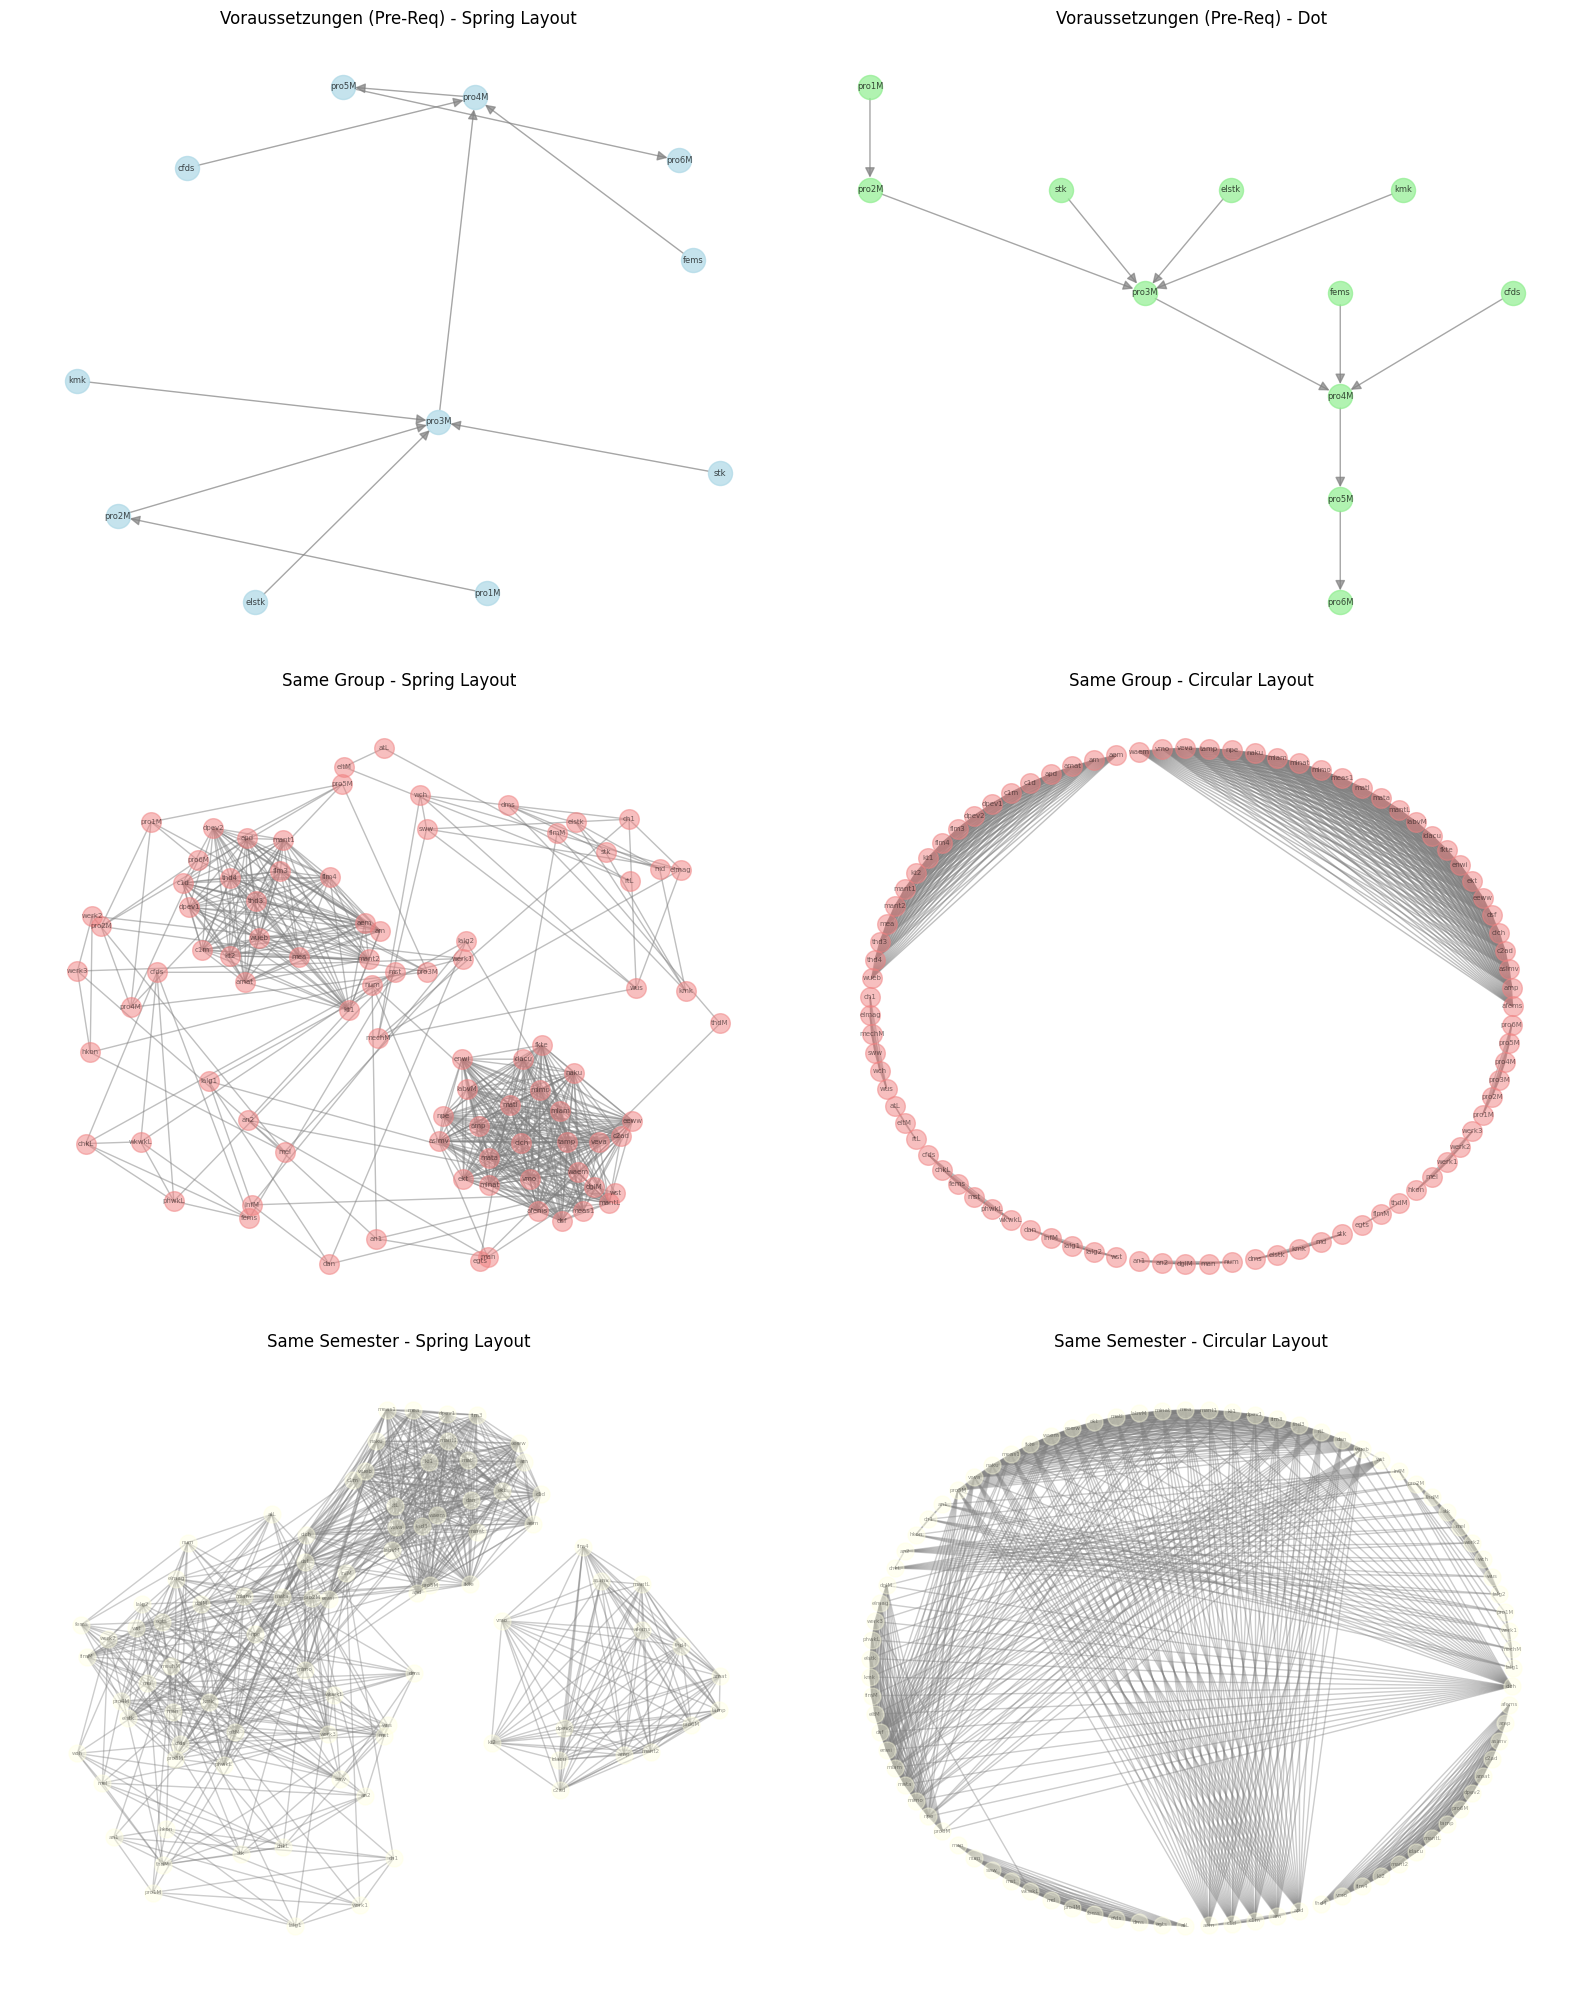


Anzahl Knoten und Kanten pro Edge-Typ:
Voraussetzungen: 11 Knoten, 10 Kanten
Same Group: 87 Knoten, 544 Kanten
Same Semester: 87 Knoten, 768 Kanten


In [15]:
# Visualisierung 1: Netzwerk-Layouts nach Edge-Typ
# Erstelle separate Graphen für jeden Edge-Typ
G_pre_req = nx.from_pandas_edgelist(edges_pre_req, 'Source', 'Target', 
                                     edge_attr=['Type', 'Label'], create_using=nx.DiGraph())
G_same_group = nx.from_pandas_edgelist(edges_same_group, 'Source', 'Target', 
                                        edge_attr=['Type', 'Label'], create_using=nx.Graph())
G_same_semester = nx.from_pandas_edgelist(edges_same_semester, 'Source', 'Target', 
                                           edge_attr=['Type', 'Label'], create_using=nx.Graph())

# Füge Node-Attribute hinzu
for graph in [G_pre_req, G_same_group, G_same_semester]:
    for node in graph.nodes():
        node_data = nodes[nodes['Id'] == node].iloc[0] if len(nodes[nodes['Id'] == node]) > 0 else None
        if node_data is not None:
            graph.nodes[node]['Name'] = node_data.get('Name', '')
            graph.nodes[node]['Gruppe'] = node_data.get('Gruppe', '')
            graph.nodes[node]['Semester'] = node_data.get('Semester', '')

fig, axes = plt.subplots(3, 2, figsize=(16, 20))

# 1. Voraussetzungen (Pre-Req) - Spring Layout
ax = axes[0, 0]
pos = nx.spring_layout(G_pre_req, k=1.5, iterations=50)
nx.draw(G_pre_req, pos, ax=ax, with_labels=True, node_color='lightblue',
        node_size=300, font_size=6, arrows=True, arrowsize=15, edge_color='gray', alpha=0.7)
ax.set_title('Voraussetzungen (Pre-Req) - Spring Layout')

# 2. Voraussetzungen (Pre-Req) - Hierarchisches Layout
ax = axes[0, 1]
layout_type = 'Spring'
if nx.is_directed_acyclic_graph(G_pre_req):
    try:
        pos = nx.nx_agraph.graphviz_layout(G_pre_req, prog='dot')
        layout_type = 'Dot'
    except (ImportError, AttributeError):
        try:
            levels = {}
            for node in G_pre_req.nodes():
                if G_pre_req.in_degree(node) == 0:
                    levels[node] = 0
                else:
                    levels[node] = max(levels.get(pred, 0) for pred in G_pre_req.predecessors(node)) + 1
            from collections import defaultdict
            nodes_by_level = defaultdict(list)
            for node, level in levels.items():
                nodes_by_level[level].append(node)
            pos = {}
            max_level = max(levels.values()) if levels else 0
            y_spacing = 2.0
            for level in range(max_level + 1):
                nodes_in_level = nodes_by_level[level]
                x_spacing = 3.0 / max(len(nodes_in_level), 1)
                for i, node in enumerate(nodes_in_level):
                    pos[node] = (i * x_spacing - len(nodes_in_level) * x_spacing / 2, 
                                (max_level - level) * y_spacing)
            layout_type = 'Hierarchical (Fallback)'
        except:
            pos = nx.spring_layout(G_pre_req, k=2, iterations=50)
else:
    pos = nx.spring_layout(G_pre_req, k=2, iterations=50)
nx.draw(G_pre_req, pos, ax=ax, with_labels=True, node_color='lightgreen',
        node_size=300, font_size=6, arrows=True, arrowsize=15, edge_color='gray', alpha=0.7)
ax.set_title(f'Voraussetzungen (Pre-Req) - {layout_type}')

# 3. Same Group - Spring Layout
ax = axes[1, 0]
pos = nx.spring_layout(G_same_group, k=1, iterations=50)
nx.draw(G_same_group, pos, ax=ax, with_labels=True, node_color='lightcoral',
        node_size=200, font_size=5, edge_color='gray', alpha=0.5)
ax.set_title('Same Group - Spring Layout')

# 4. Same Group - Circular Layout
ax = axes[1, 1]
pos = nx.circular_layout(G_same_group)
nx.draw(G_same_group, pos, ax=ax, with_labels=True, node_color='lightcoral',
        node_size=200, font_size=5, edge_color='gray', alpha=0.5)
ax.set_title('Same Group - Circular Layout')

# 5. Same Semester - Spring Layout
ax = axes[2, 0]
pos = nx.spring_layout(G_same_semester, k=1, iterations=50)
nx.draw(G_same_semester, pos, ax=ax, with_labels=True, node_color='lightyellow',
        node_size=150, font_size=4, edge_color='gray', alpha=0.4)
ax.set_title('Same Semester - Spring Layout')

# 6. Same Semester - Circular Layout
ax = axes[2, 1]
pos = nx.circular_layout(G_same_semester)
nx.draw(G_same_semester, pos, ax=ax, with_labels=True, node_color='lightyellow',
        node_size=150, font_size=4, edge_color='gray', alpha=0.4)
ax.set_title('Same Semester - Circular Layout')

plt.tight_layout()
plt.show()

print(f"\nAnzahl Knoten und Kanten pro Edge-Typ:")
print(f"Voraussetzungen: {G_pre_req.number_of_nodes()} Knoten, {G_pre_req.number_of_edges()} Kanten")
print(f"Same Group: {G_same_group.number_of_nodes()} Knoten, {G_same_group.number_of_edges()} Kanten")
print(f"Same Semester: {G_same_semester.number_of_nodes()} Knoten, {G_same_semester.number_of_edges()} Kanten")


**Visualisierung 1: Netzwerk-Layouts nach Edge-Typ**

Die Visualisierungen zeigen das Netzwerk **getrennt nach Edge-Typen** für bessere Übersichtlichkeit und Verständlichkeit. Das kombinierte Netzwerk wäre zu dicht und unübersichtlich.

**Voraussetzungen (Pre-Req) - Die Hierarchie:**
- **Spring Layout:** Zeigt die natürliche Struktur der Voraussetzungen basierend auf Verbindungen. Module mit ähnlichen Voraussetzungen werden nahe beieinander positioniert.
- **Hierarchisches Layout (Dot/Fallback):** Dies ist das **wichtigste Layout** für die Voraussetzungshierarchie. Es zeigt die Hierarchie klar - Module ohne Voraussetzungen (Quellen) sind oben, Module mit vielen Voraussetzungen (Senken) sind unten. Die Projektsequenz (pro1M → pro2M → ... → pro6M) sollte als vertikale Kette von oben nach unten sichtbar sein.

**Same Group - Cliquen-Struktur:**
- **Spring Layout & Circular Layout:** Zeigen, welche Module derselben Gruppe miteinander verbunden sind.
- **Struktur:** Module derselben Gruppe sind vollständig miteinander verbunden (Cliquen-Struktur), daher sind diese Visualisierungen sehr dicht - grosse Gruppen bilden vollständig verbundene Cliquen.
- **Bedeutung:** Diese Visualisierungen zeigen die interne Kohäsion innerhalb von Gruppen - Module derselben Gruppe sind alle miteinander verbunden.

**Same Semester - Semester-basierte Cliquen:**
- **Spring Layout & Circular Layout:** Zeigen, welche Module desselben Semesters miteinander verbunden sind.
- **Struktur:** Module desselben Semesters sind vollständig miteinander verbunden (Cliquen-Struktur), daher sind diese Visualisierungen sehr dicht - grosse Semester bilden vollständig verbundene Cliquen.
- **Bedeutung:** Diese Visualisierungen zeigen, welche Module gleichzeitig belegt werden können - Module desselben Semesters sind alle miteinander verbunden.

**Vorteile der Trennung:**
- **Übersichtlichkeit:** Die Trennung nach Edge-Typen macht die Visualisierungen übersichtlicher und verständlicher.
- **Fokussierung:** Jede Visualisierung zeigt einen spezifischen Aspekt des Netzwerks - Voraussetzungen (Hierarchie), Same Group (Gruppen-Kohäsion), Same Semester (Semester-Zuordnung).
- **Vermeidung von Überlastung:** Das kombinierte Netzwerk wäre sehr dicht und unübersichtlich, da Same Group und Same Semester Kanten Cliquen-Strukturen bilden (jedes Modul ist mit allen anderen in derselben Gruppe/Semester verbunden).

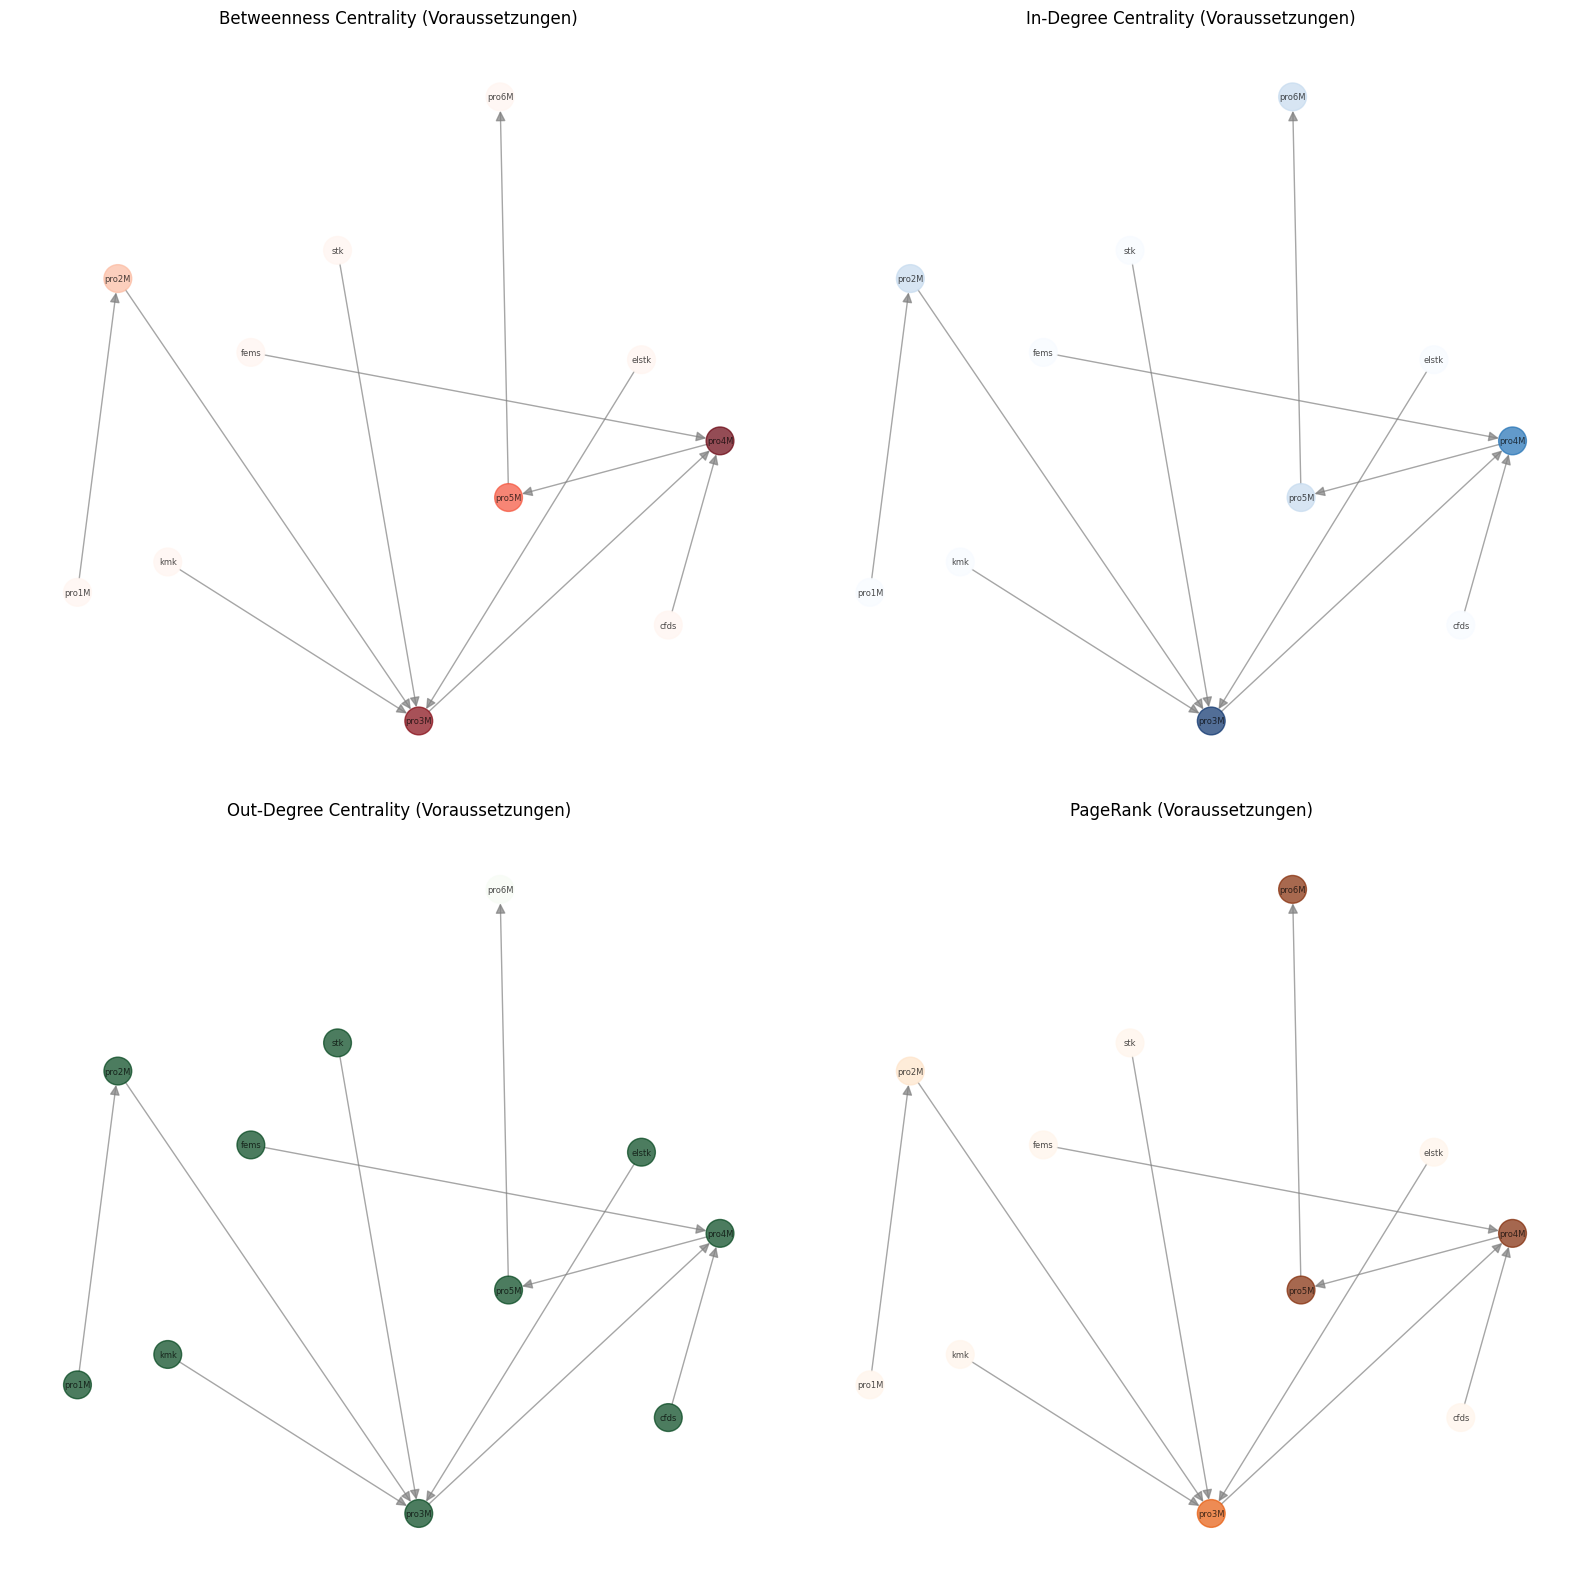

In [ ]:
# Visualisierung 2: Netzwerk mit Zentralitätsmassen (Voraussetzungen)
# Verwende nur das Pre-Req-Netzwerk für bessere Übersichtlichkeit
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
pos = nx.spring_layout(G_pre_req, k=1.5, iterations=50)

# Betweenness Centrality (nur auf Pre-Req berechnet für Voraussetzungsstruktur)
ax = axes[0, 0]
betw_pre = nx.betweenness_centrality(G_pre_req)
betw_values = [betw_pre.get(n, 0) for n in G_pre_req.nodes()]
nx.draw(G_pre_req, pos, ax=ax, with_labels=True, node_color=betw_values,
        node_size=400, font_size=6, arrows=True, arrowsize=15,
        cmap=plt.cm.Reds, edge_color='gray', alpha=0.7)
ax.set_title('Betweenness Centrality (Voraussetzungen)')

# In-Degree Centrality (nur auf Pre-Req)
ax = axes[0, 1]
in_deg_pre = nx.in_degree_centrality(G_pre_req)
in_deg_values = [in_deg_pre.get(n, 0) for n in G_pre_req.nodes()]
nx.draw(G_pre_req, pos, ax=ax, with_labels=True, node_color=in_deg_values,
        node_size=400, font_size=6, arrows=True, arrowsize=15,
        cmap=plt.cm.Blues, edge_color='gray', alpha=0.7)
ax.set_title('In-Degree Centrality (Voraussetzungen)')

# Out-Degree Centrality (nur auf Pre-Req)
ax = axes[1, 0]
out_deg_pre = nx.out_degree_centrality(G_pre_req)
out_deg_values = [out_deg_pre.get(n, 0) for n in G_pre_req.nodes()]
nx.draw(G_pre_req, pos, ax=ax, with_labels=True, node_color=out_deg_values,
        node_size=400, font_size=6, arrows=True, arrowsize=15,
        cmap=plt.cm.Greens, edge_color='gray', alpha=0.7)
ax.set_title('Out-Degree Centrality (Voraussetzungen)')

# PageRank (nur auf Pre-Req)
ax = axes[1, 1]
pagerank_pre = nx.pagerank(G_pre_req)
pagerank_values = [pagerank_pre.get(n, 0) for n in G_pre_req.nodes()]
nx.draw(G_pre_req, pos, ax=ax, with_labels=True, node_color=pagerank_values,
        node_size=400, font_size=6, arrows=True, arrowsize=15,
        cmap=plt.cm.Oranges, edge_color='gray', alpha=0.7)
ax.set_title('PageRank (Voraussetzungen)')

plt.tight_layout()
plt.show()


**Visualisierung 2: Netzwerk mit Zentralitätsmassen**

Die farbliche Kodierung der Knoten nach verschiedenen Zentralitätsmassen zeigt die wichtigsten Module:

- **Betweenness Centrality (Rot):** pro3M und pro4M sind wie erwartet am dunkelsten rot - sie sind die kritischen Engpässe. Diese Visualisierung macht deutlich, welche Module den meisten Verkehr durchlaufen.

- **In-Degree Centrality (Blau):** pro3M und pro4M sind ebenfalls wie erwartet am dunkelsten blau - sie haben die meisten Voraussetzungen. Dies zeigt, welche Module fundamentale Bausteine sind.

- **Out-Degree Centrality (Grün):** Viele Module sind wie erwartet ähnlich hellgrün, da die meisten nur eine ausgehende Verbindung haben. Dies zeigt die spärliche Struktur des Netzwerks.

- **PageRank (Lila):** pro4M und pro5M sind wie erwartet am dunkelsten lila - sie sind strategisch wichtig und mit anderen zentralen Modulen verbunden. Dies zeigt die "Wichtigkeit" der Module im Gesamtnetzwerk.

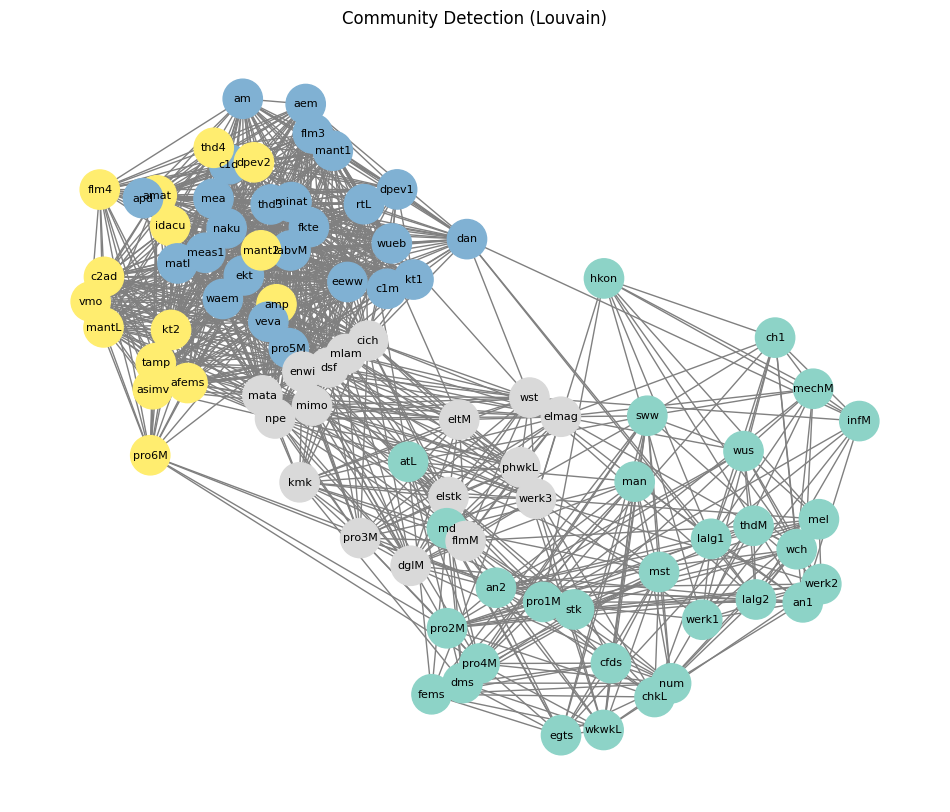

In [17]:
# Visualisierung 3: Communities
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
pos = nx.spring_layout(G_undir, k=1, iterations=50)

# Färbe nach Communities
node_colors = [partition.get(node, 0) for node in G_undir.nodes()]
nx.draw(G_undir, pos, ax=ax, with_labels=True, node_color=node_colors,
        node_size=800, font_size=8, cmap=plt.cm.Set3, edge_color='gray')
ax.set_title('Community Detection (Louvain)')
plt.show()


**Visualisierung 3: Community Detection**

Die farbliche Gruppierung nach Communities zeigt natürliche Cluster im **kombinierten Netzwerk** (alle Edge-Typen):

- **Farbkodierung:** Module der gleichen Farbe gehören zur gleichen Community - sie sind stärker miteinander als mit Modulen in anderen Communities verbunden.
- **Community-Bildung:** Durch "Same Group" und "Same Semester" Kanten bilden Module derselben Gruppe/Semesters typischerweise Communities, da sie vollständig miteinander verbunden sind (Cliquen-Struktur).
- **Einflussfaktoren:** Die Communities werden durch alle Verbindungstypen beeinflusst:
  - Same Group Kanten: Module derselben Gruppe bilden Communities
  - Same Semester Kanten: Module desselben Semesters können Communities bilden
  - Voraussetzungen: Verbindungen zwischen verschiedenen Gruppen können Communities über Gruppen- und Semestergrenzen hinweg schaffen
- **Bedeutung:** Die Communities entsprechen funktionalen Gruppen basierend auf allen Verbindungstypen, nicht nur administrativen Kategorien. Dies zeigt, wie Module tatsächlich im Netzwerk verbunden sind und zusammenarbeiten können.
- **Praktische Anwendung:** Communities können helfen, zusammengehörige Module zu identifizieren, die möglicherweise gemeinsam geplant oder koordiniert werden sollten.

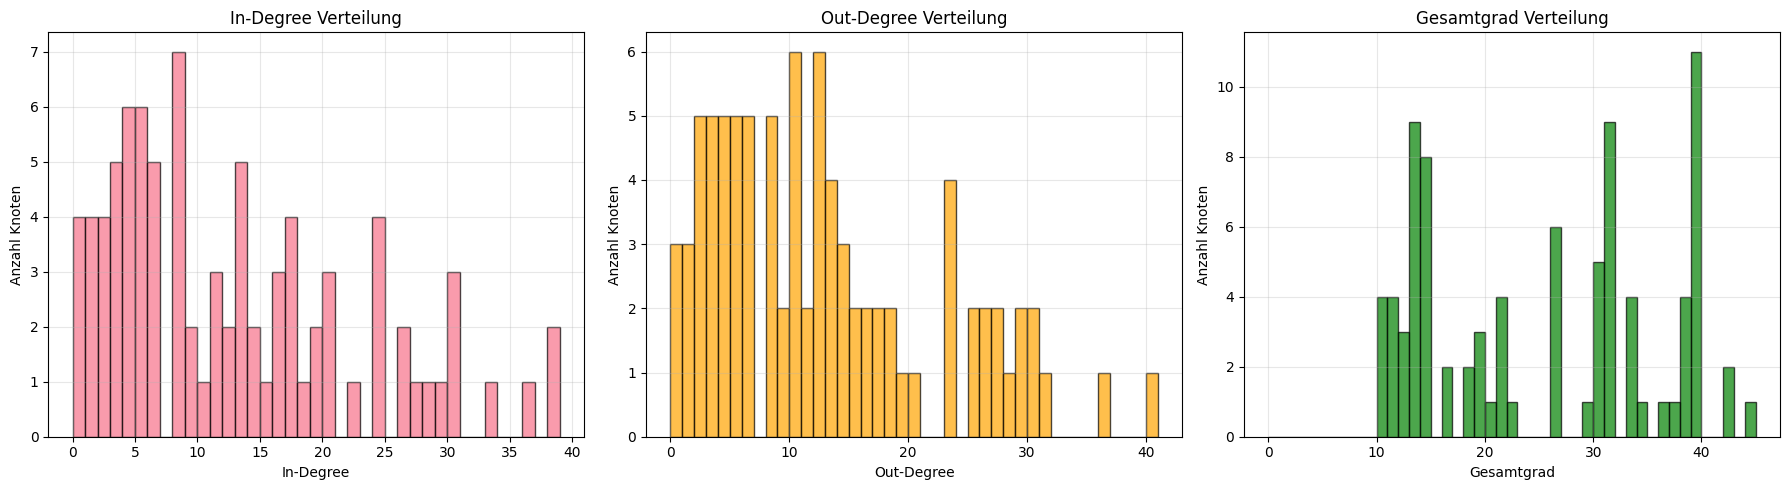

In [18]:
# Visualisierung 4: Grad-Verteilung
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# In-Degree Verteilung
ax = axes[0]
in_degrees = [G.in_degree(n) for n in G.nodes()]
ax.hist(in_degrees, bins=range(max(in_degrees)+2), edgecolor='black', alpha=0.7)
ax.set_xlabel('In-Degree')
ax.set_ylabel('Anzahl Knoten')
ax.set_title('In-Degree Verteilung')
ax.grid(True, alpha=0.3)

# Out-Degree Verteilung
ax = axes[1]
out_degrees = [G.out_degree(n) for n in G.nodes()]
ax.hist(out_degrees, bins=range(max(out_degrees)+2), edgecolor='black', alpha=0.7, color='orange')
ax.set_xlabel('Out-Degree')
ax.set_ylabel('Anzahl Knoten')
ax.set_title('Out-Degree Verteilung')
ax.grid(True, alpha=0.3)

# Gesamtgrad Verteilung
ax = axes[2]
total_degrees = [G.degree(n) for n in G.nodes()]
ax.hist(total_degrees, bins=range(max(total_degrees)+2), edgecolor='black', alpha=0.7, color='green')
ax.set_xlabel('Gesamtgrad')
ax.set_ylabel('Anzahl Knoten')
ax.set_title('Gesamtgrad Verteilung')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Visualisierung 4: Grad-Verteilungen**

Die drei Histogramme zeigen die Verteilung der Verbindungen im **kombinierten Netzwerk** (alle Edge-Typen):

- **In-Degree Verteilung:**
  - Zeigt die Verteilung der eingehenden Verbindungen (Voraussetzungen, Same Group, Same Semester).
  - **Interpretation:** Module ohne eingehende Verbindungen haben In-Degree 0 (Quellen). Die Verteilung zeigt, wie viele Module auf jedes Modul aufbauen oder mit ihm verbunden sind.
  - **Typische Muster:** Module auf höheren Ebenen oder in grossen Gruppen/Semestern haben höhere In-Degree-Werte.

- **Out-Degree Verteilung:**
  - Zeigt die Verteilung der ausgehenden Verbindungen (Voraussetzungen, Same Group, Same Semester).
  - **Interpretation:** Module ohne ausgehende Verbindungen haben Out-Degree 0 (Senken). Die Verteilung zeigt, wie viele Module jedes Modul voraussetzt oder mit ihm verbunden ist.
  - **Typische Muster:** Module auf niedrigeren Ebenen oder in grossen Gruppen/Semestern haben höhere Out-Degree-Werte.

- **Gesamtgrad Verteilung:**
  - Kombiniert beide Richtungen und alle Edge-Typen.
  - **Hinweis:** Durch "Same Group" und "Same Semester" Kanten haben Module typischerweise deutlich höhere Grade als bei einem reinen Voraussetzungsnetzwerk, da Module derselben Gruppe/Semesters vollständig miteinander verbunden sind.
  - **Interpretation:** Die Verteilung zeigt, wie stark Module vernetzt sind - Module in grossen Gruppen/Semestern haben höhere Grade.

**Gesamtinterpretation der Visualisierungen:**

Die Visualisierungen bestätigen und illustrieren die Ergebnisse der quantitativen Analysen:
- Die **hierarchische Struktur** der Voraussetzungen ist im hierarchischen Layout klar erkennbar - Quellen oben, Senken unten.
- Die **kritischen Module** (hohes Betweenness) heben sich in den Zentralitäts-Visualisierungen durch dunklere Farben hervor.
- Die **Grad-Verteilungen** zeigen die Vernetzung durch alle Edge-Typen - Module in grossen Gruppen/Semestern haben höhere Grade.
- Die **Community-Struktur** zeigt funktionale Gruppierungen basierend auf allen Verbindungstypen - nicht nur administrative Kategorien.

**Praktische Anwendung:**
- Die Visualisierungen sind besonders nützlich für die Kommunikation mit Stakeholdern (Dozenten, Studienplanung, Studierende).
- Sie machen komplexe Netzwerkstrukturen visuell verständlich und zeigen auf einen Blick, welche Module kritisch sind.
- Die Visualisierungen können helfen, Probleme zu identifizieren, Zusammenhänge zu verstehen und Entscheidungen zu treffen.


## 15. Simulationen - Was-wäre-wenn Szenarien


In [19]:
print("=== Was-wäre-wenn Szenarien ===")

# Szenario 1: Was passiert, wenn wir eine neue Verbindung hinzufügen?
print("\nSzenario 1: Neue Verbindung zwischen isolierten Modulen")
isolated_pairs = [(u, v) for u in G.nodes() for v in G.nodes() 
                  if u != v and not G.has_edge(u, v) and G.degree(u) == 0 and G.degree(v) == 0]
if isolated_pairs:
    test_edge = isolated_pairs[0]
    G_test = G.copy()
    G_test.add_edge(test_edge[0], test_edge[1])
    print(f"  Hinzugefügt: {test_edge[0]} -> {test_edge[1]}")
    print(f"  Neue Komponenten: {len(list(nx.weakly_connected_components(G_test)))}")
else:
    print("  Keine isolierten Paare gefunden")

# Szenario 2: Was passiert, wenn wir kritische Module entfernen?
print("\nSzenario 2: Entfernung kritischer Module")
critical_nodes = cent_df.sort_values('Betweenness', ascending=False).head(2).index.tolist()
G_scenario = G.copy()
G_scenario.remove_nodes_from(critical_nodes)
print(f"  Entfernt: {critical_nodes}")
print(f"  Verbleibende Knoten: {G_scenario.number_of_nodes()}")
print(f"  Verbleibende Kanten: {G_scenario.number_of_edges()}")
print(f"  Neue Komponenten: {len(list(nx.weakly_connected_components(G_scenario)))}")

# Szenario 3: Was passiert, wenn wir alle Verbindungen einer Gruppe entfernen?
print("\nSzenario 3: Entfernung aller Verbindungen einer Gruppe")
if len(nodes['Gruppe'].dropna().unique()) > 0:
    test_group = nodes['Gruppe'].dropna().unique()[0]
    group_nodes = [n for n in G.nodes() if G.nodes[n].get('Gruppe') == test_group]
    G_group_removed = G.copy()
    edges_to_remove = [(u, v) for u, v in G_group_removed.edges() 
                       if u in group_nodes or v in group_nodes]
    G_group_removed.remove_edges_from(edges_to_remove)
    print(f"  Gruppe: {test_group}")
    print(f"  Entfernte Kanten: {len(edges_to_remove)}")
    print(f"  Neue Komponenten: {len(list(nx.weakly_connected_components(G_group_removed)))}")


=== Was-wäre-wenn Szenarien ===

Szenario 1: Neue Verbindung zwischen isolierten Modulen
  Keine isolierten Paare gefunden

Szenario 2: Entfernung kritischer Module
  Entfernt: ['enwi', 'pro4M']
  Verbleibende Knoten: 85
  Verbleibende Kanten: 1023
  Neue Komponenten: 1

Szenario 3: Entfernung aller Verbindungen einer Gruppe
  Gruppe: Grundlagen: Mathematik 1
  Entfernte Kanten: 73
  Neue Komponenten: 6


### Interpretation der Was-wäre-wenn Szenarien

**Hinweis:** Die Was-wäre-wenn Analysen betrachten das **vollständige Netzwerk** (alle Edge-Typen kombiniert). Durch "Same Group" und "Same Semester" Kanten ist das Netzwerk stärker verbunden als ein reines Voraussetzungsnetzwerk, was die Robustheit erhöht, aber die Auswirkungen von Änderungen sind dennoch relevant.

**Szenario 1: Neue Verbindung zwischen isolierten Modulen**

- **Ziel:** Testen, ob die Hinzufügung einer Verbindung isolierte Module verbinden kann.
- **Ergebnis:** Durch die Kombination aller Edge-Typen sind die meisten Module bereits verbunden - Module mit Grad 0 (vollständig isoliert) sind selten, da Module derselben Gruppe/Semesters verbunden sind.
- **Bedeutung:** Das Netzwerk ist bereits gut verbunden - zusätzliche Verbindungen würden wahrscheinlich nur die Dichte erhöhen, nicht isolierte Module verbinden.

**Szenario 2: Entfernung kritischer Module**

- **Ziel:** Testen, welche Auswirkungen die Entfernung kritischer Module (hohes Betweenness) hat.
- **Auswirkungen:** Die Entfernung kritischer Module kann das Netzwerk in mehr Komponenten aufteilen, was bedeutet, dass Studenten nicht mehr von bestimmten Modulen zu anderen gelangen können.
- **Verbleibende Struktur:** Durch "Same Group" und "Same Semester" Kanten bleiben mehr Verbindungen erhalten als bei einem reinen Voraussetzungsnetzwerk - das Netzwerk ist robuster.
- **Bedeutung:** Kritische Module (hohes Betweenness) sind wichtig für die Netzwerk-Konnektivität. Ihre Entfernung kann die Struktur erheblich beeinträchtigen, aber das kombinierte Netzwerk ist robuster als ein reines Voraussetzungsnetzwerk.

**Szenario 3: Entfernung aller Verbindungen einer Gruppe**

- **Ziel:** Testen, welche Auswirkungen die Entfernung aller Verbindungen einer Gruppe hat.
- **Auswirkungen:** Gruppen mit vielen Modulen haben typischerweise sehr viele Verbindungen durch "Same Group" Kanten (Cliquen-Struktur). Die Entfernung aller Verbindungen einer Gruppe kann erhebliche Auswirkungen haben, da viele Module gleichzeitig ihre Verbindungen verlieren.
- **Bedeutung:** Die Analyse zeigt, wie abhängig das Netzwerk von bestimmten Gruppen ist. Grosse Gruppen haben grosse Auswirkungen, wenn ihre Verbindungen entfernt werden.

**Gesamtinterpretation der Simulationen:**

Die Was-wäre-wenn Analysen zeigen die **Robustheit und Fragilität** des Curriculums:
- **Robustheit:** Durch die Kombination aller Edge-Typen ist das Netzwerk robuster als ein reines Voraussetzungsnetzwerk - Same Group und Same Semester Verbindungen bieten alternative Wege.
- **Fragilität:** Die Abhängigkeit von kritischen Modulen macht das System dennoch anfällig - ein Ausfall kritischer Module kann die Netzwerkstruktur erheblich beeinträchtigen.
- **Risikobewertung:** Das Curriculum hat ein **Systemrisiko** - die Konzentration der Abhängigkeiten auf kritische Module ist relevant für die Planung.

**Empfehlungen für die Studienplanung:**
1. **Diversifizierung:** Überlegung, ob alternative Voraussetzungsstrukturen möglich sind, um die Abhängigkeit von kritischen Modulen zu reduzieren.
2. **Robustheit:** Besondere Aufmerksamkeit auf die Planung und Durchführung kritischer Module (Redundanz, Mehrfachangebot, Frühwarnsysteme).
3. **Monitoring:** Regelmässige Überwachung der Studentenfortschritte in kritischen Modulen.
4. **Notfallplanung:** Entwicklung von Strategien für den Fall, dass kritische Module nicht angeboten werden können.


## 16. Erweiterte Analysen - Bipartite Eigenschaften und mehr


In [20]:
print("=== Erweiterte Strukturanalysen ===")

# Prüfe auf bipartite Eigenschaften (Quellen vs. Senken)
sources = [n for n in G.nodes() if G.in_degree(n) == 0]
sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
middle = [n for n in G.nodes() if n not in sources and n not in sinks]

print(f"Quellen: {len(sources)} ({sources})")
print(f"Senken: {len(sinks)} ({sinks})")
print(f"Mittlere Knoten: {len(middle)}")

# Analysiere Pfade von Quellen zu Senken
source_to_sink_paths = []
for source in sources:
    for sink in sinks:
        if nx.has_path(G, source, sink):
            path = nx.shortest_path(G, source, sink)
            source_to_sink_paths.append({
                'Source': source,
                'Sink': sink,
                'Length': len(path) - 1,
                'Path': path
            })

if source_to_sink_paths:
    path_df = pd.DataFrame(source_to_sink_paths)
    print(f"\nAnzahl Quellen-zu-Senken-Pfade: {len(path_df)}")
    print(f"Durchschnittliche Länge: {path_df['Length'].mean():.2f}")
    print(f"Längster Pfad: {path_df['Length'].max()} Schritte")
    
    # Häufigste Quellen und Senken
    print("\nHäufigste Quellen (in Pfaden):")
    print(path_df['Source'].value_counts().head())
    print("\nHäufigste Senken (in Pfaden):")
    print(path_df['Sink'].value_counts().head())

# Analysiere Knoten, die viele Pfade durchlaufen
node_path_counts = defaultdict(int)
for path_info in source_to_sink_paths:
    for node in path_info['Path'][1:-1]:  # Ohne Start und Ende
        node_path_counts[node] += 1

if node_path_counts:
    print("\nKnoten, die in den meisten Pfaden vorkommen:")
    sorted_nodes = sorted(node_path_counts.items(), key=lambda x: x[1], reverse=True)
    for node, count in sorted_nodes[:5]:
        print(f"  {node}: {count} Pfade")


=== Erweiterte Strukturanalysen ===
Quellen: 4 (['afems', 'aem', 'atL', 'an1'])
Senken: 3 (['wueb', 'wus', 'wkwkL'])
Mittlere Knoten: 80

Anzahl Quellen-zu-Senken-Pfade: 12
Durchschnittliche Länge: 2.33
Längster Pfad: 4 Schritte

Häufigste Quellen (in Pfaden):
Source
afems    3
aem      3
atL      3
an1      3
Name: count, dtype: int64

Häufigste Senken (in Pfaden):
Sink
wueb     4
wus      4
wkwkL    4
Name: count, dtype: int64

Knoten, die in den meisten Pfaden vorkommen:
  cich: 2 Pfade
  phwkL: 2 Pfade
  amat: 1 Pfade
  elmag: 1 Pfade
  dan: 1 Pfade


### Interpretation der erweiterten Strukturanalysen

**Hinweis:** Die erweiterten Strukturanalysen betrachten die **Voraussetzungsstruktur** (Quellen-zu-Senken-Pfade basieren auf gerichteten Voraussetzungen). Diese Analyse fokussiert auf die Pfade von Quellen (Modulen ohne Voraussetzungen) zu Senken (Modulen ohne nachfolgende Module).

**Quellen-zu-Senken-Pfade - Die Wege durch das Curriculum:**
- **Definition:** Pfade von Quellen (Modulen ohne eingehende Voraussetzungen) zu Senken (Modulen ohne ausgehende Voraussetzungen) zeigen die möglichen Wege durch das Curriculum.
- **Anzahl:** Die Anzahl der Pfade hängt von der Voraussetzungsstruktur ab - eine hohe Anzahl zeigt viele alternative Wege, eine niedrige Anzahl zeigt wenige Wege.
- **Durchschnittliche Pfadlänge:** Zeigt, wie viele Voraussetzungsschritte im Durchschnitt zwischen Start- und Endmodulen liegen. Ein höherer Wert zeigt eine tiefere Hierarchie.
- **Häufigste Ziele:** **pro6M** (Bachelor Thesis) ist typischerweise das häufigste Ziel, da es das Endziel des Curriculums ist - viele Wege führen dorthin.

**Kritische Knoten in Pfaden - Pflichtmodule:**
- Module, die in vielen Quellen-zu-Senken-Pfaden vorkommen, sind kritische Knotenpunkte im Curriculum.
- **Bedeutung:** Diese Module sind **Pflichtmodule** im wahren Sinne - fast alle Studienwege führen durch sie. Studenten können diese Module nicht umgehen.
- **Typische Eigenschaften:** Die Projektsequenz (pro3M, pro4M, pro5M, pro6M) ist typischerweise besonders kritisch, da diese Module sequenziell aufeinander aufbauen und viele Wege dorthin führen.

**Bedeutung für die Studienplanung:**
- **Flexibilität:** Die Anzahl alternativer Pfade zeigt die Flexibilität der Studienstruktur - viele Pfade bieten mehr Flexibilität, wenige Pfade zeigen eine starre Struktur.
- **Kritische Module:** Studenten haben **begrenzte Flexibilität** in der Projektsequenz - viele Wege führen durch kritische Module zu pro6M. Diese Module sind obligatorisch für die meisten Studenten.
- **Empfehlung:** Kritische Module sollten besonders gut unterstützt werden (z.B. zusätzliche Tutorien, flexible Prüfungstermine), da sie für viele Studenten obligatorisch sind und das Erreichen des Studienziels blockieren können, wenn sie nicht bestanden werden.

**Praktische Konsequenzen:**
- **Ausweichmöglichkeiten:** Studenten, die in kritischen Modulen scheitern, haben möglicherweise begrenzte Ausweichmöglichkeiten - alternative Wege sind begrenzt.
- **Druck:** Dies erhöht den Druck auf diese Module - Studenten müssen diese Module bestehen, um das Studium erfolgreich abzuschliessen.
- **Prüfungsplanung:** Diese Erkenntnis sollte bei der Prüfungsplanung berücksichtigt werden - kritische Module benötigen robuste Prüfungsstrukturen (mehrere Termine, Wiederholungsmöglichkeiten).


## 17. Korrelationsanalyse - Zusammenhänge zwischen Metriken


=== Korrelationsanalyse zwischen Metriken ===

Korrelationsmatrix (Top-Korrelationen):
  InDegree <-> InDegree_abs: 1.000
  OutDegree <-> OutDegree_abs: 1.000
  Closeness <-> Erreichbar_von: 0.943
  Closeness <-> InDegree_abs: 0.932
  InDegree <-> Closeness: 0.932
  InDegree <-> Katz: 0.921
  Katz <-> InDegree_abs: 0.921
  Erreichbar_von <-> Erreichbar: -0.877
  Closeness <-> Katz: 0.860
  OutDegree_abs <-> Erreichbar: 0.839


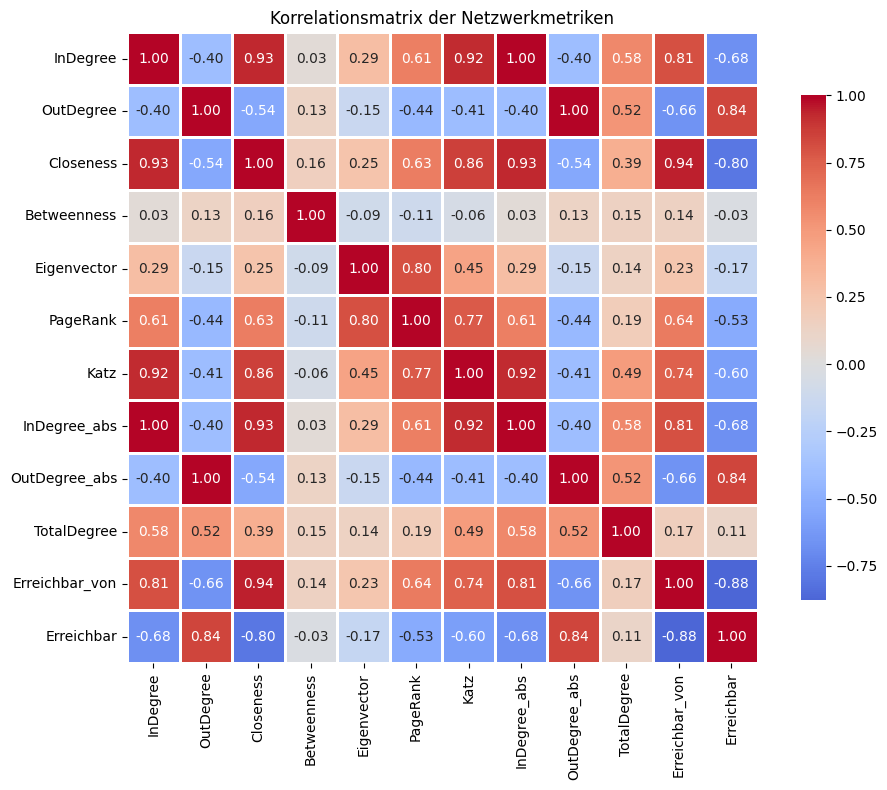

In [21]:
print("=== Korrelationsanalyse zwischen Metriken ===")

# Erstelle umfassende Metrik-Tabelle
metrics_df = cent_df.copy()
metrics_df['InDegree_abs'] = [G.in_degree(n) for n in G.nodes()]
metrics_df['OutDegree_abs'] = [G.out_degree(n) for n in G.nodes()]
metrics_df['TotalDegree'] = [G.degree(n) for n in G.nodes()]

# Füge Erreichbarkeits-Metriken hinzu
metrics_df['Erreichbar_von'] = metrics_df.index.map(reachable_from_counts)
metrics_df['Erreichbar'] = metrics_df.index.map(reachable_counts)

# Korrelationsmatrix
corr_matrix = metrics_df.corr()
print("\nKorrelationsmatrix (Top-Korrelationen):")
# Zeige nur hohe Korrelationen
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
for col1, col2, corr in high_corr[:10]:
    print(f"  {col1} <-> {col2}: {corr:.3f}")

# Visualisiere Korrelationsmatrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8}, ax=ax)
ax.set_title('Korrelationsmatrix der Netzwerkmetriken')
plt.tight_layout()
plt.show()


### Interpretation der Korrelationsanalyse

**Hinweis:** Die Korrelationsanalyse vergleicht verschiedene Zentralitätsmasse, die auf dem **kombinierten Netzwerk** (alle Edge-Typen) berechnet werden. Durch die Kombination aller Edge-Typen sind die Zentralitätswerte anders als bei einem reinen Voraussetzungsnetzwerk, da alle Verbindungstypen berücksichtigt werden.

**Starke Korrelationen - Ähnliche Module, verschiedene Perspektiven:**
- **PageRank ↔ Erreichbar_von:** Module, die von vielen anderen Modulen erreicht werden können (hohe Erreichbarkeit), haben typischerweise hohen PageRank. Dies bestätigt, dass zentrale Ziele wie pro6M (Bachelor Thesis) sowohl durch Erreichbarkeit als auch durch PageRank identifiziert werden.
- **InDegree ↔ Katz:** Module mit vielen eingehenden Verbindungen haben typischerweise hohe Katz-Zentralität. Beide Masse identifizieren fundamentale Bausteine des Curriculums - Module, auf denen viele andere aufbauen.
- **InDegree ↔ TotalDegree:** Die Korrelation zeigt, ob die meisten Verbindungen eingehend sind (hierarchische Struktur, wo Module auf anderen aufbauen) oder ob es eine ausgewogenere Verteilung gibt.

**Bedeutung für die Identifikation kritischer Module:**
- **Konsistenz der Metriken:** Wenn verschiedene Zentralitätsmasse stark korrelieren und zu ähnlichen Ergebnissen führen, ist die Identifikation kritischer Module robust - die Module sind tatsächlich wichtig, unabhängig vom verwendeten Mass.
- **Verschiedene Perspektiven:** Unterschiedliche Masse betrachten verschiedene Aspekte der Zentralität - die Korrelation zeigt, ob diese Aspekte ähnlich sind oder sich unterscheiden.
- **Kritische Module:** Module, die in mehreren Metriken als wichtig erscheinen, sind wahrscheinlich tatsächlich kritisch für das Curriculum.

**Praktische Anwendung:**
- **Robustheit:** Da verschiedene Metriken zu ähnlichen Ergebnissen führen können, können wir sicher sein, dass kritische Module (hohes Betweenness, PageRank, etc.) tatsächlich wichtig sind - die Identifikation ist robust.
- **Studienplanung:** Die Studienplanung sollte diese Erkenntnis nutzen - Module, die in mehreren Metriken als wichtig erscheinen, sollten besonders unterstützt werden.
- **Priorisierung:** Die Korrelationsanalyse hilft dabei, die Prioritäten zu setzen - Module, die in vielen Metriken wichtig sind, haben höchste Priorität für Unterstützung und Monitoring.


## 18. Netzwerk-Vergleich - Vergleich mit zufälligen Netzwerken


=== Vergleich mit zufälligen Netzwerken ===

Vergleich: Tatsächlich vs. Zufällig (Durchschnitt über 10 Zufallsnetzwerke)
                 Tatsächlich  Zufällig (Ø)  Differenz
density               0.1445        0.1445    -0.0000
clustering            0.6837        0.2698     0.4138
avg_path_length       2.0035        1.9961     0.0074
transitivity          0.7121        0.2689     0.4432


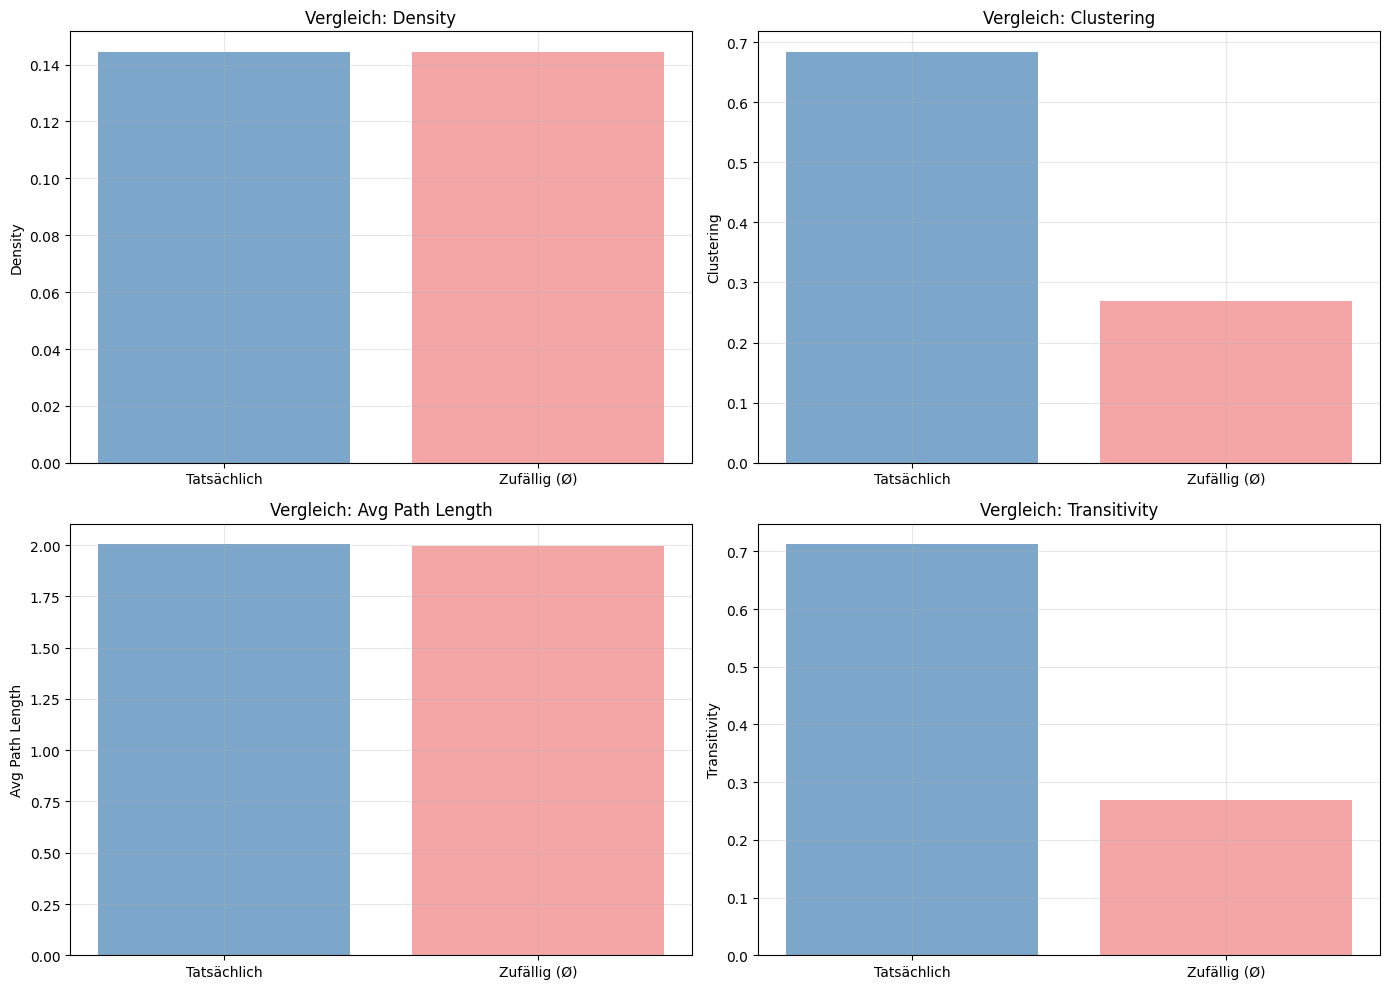

In [22]:
print("=== Vergleich mit zufälligen Netzwerken ===")

# Erstelle zufälliges Netzwerk mit gleicher Anzahl Knoten und Kanten
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

# Erstelle mehrere zufällige Netzwerke und vergleiche
random_metrics = {
    'density': [],
    'clustering': [],
    'avg_path_length': [],
    'transitivity': []
}

for i in range(10):
    G_random = nx.gnm_random_graph(n_nodes, n_edges, directed=True)
    G_random_undir = G_random.to_undirected()
    
    random_metrics['density'].append(nx.density(G_random))
    random_metrics['clustering'].append(nx.average_clustering(G_random_undir))
    
    # Durchschnittliche Pfadlänge
    path_lengths = []
    for source in G_random.nodes():
        for target in G_random.nodes():
            if source != target and nx.has_path(G_random, source, target):
                path_lengths.append(nx.shortest_path_length(G_random, source, target))
    random_metrics['avg_path_length'].append(np.mean(path_lengths) if path_lengths else 0)
    random_metrics['transitivity'].append(nx.transitivity(G_random_undir))

# Berechne Durchschnitte
random_avg = {k: np.mean(v) for k, v in random_metrics.items()}

# Vergleich mit tatsächlichem Netzwerk
actual_metrics = {
    'density': nx.density(G),
    'clustering': nx.average_clustering(G_undir),
    'avg_path_length': np.mean(path_lengths) if path_lengths else 0,
    'transitivity': nx.transitivity(G_undir)
}

print("\nVergleich: Tatsächlich vs. Zufällig (Durchschnitt über 10 Zufallsnetzwerke)")
comparison_df = pd.DataFrame({
    'Tatsächlich': actual_metrics,
    'Zufällig (Ø)': random_avg
})
comparison_df['Differenz'] = comparison_df['Tatsächlich'] - comparison_df['Zufällig (Ø)']
print(comparison_df.round(4))

# Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(['density', 'clustering', 'avg_path_length', 'transitivity']):
    ax = axes[idx]
    ax.bar(['Tatsächlich', 'Zufällig (Ø)'], 
           [actual_metrics[metric], random_avg[metric]],
           color=['steelblue', 'lightcoral'], alpha=0.7)
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'Vergleich: {metric.replace("_", " ").title()}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretation des Vergleichs mit zufälligen Netzwerken

**Hinweis:** Der Vergleich mit zufälligen Netzwerken betrachtet das **vollständige Netzwerk** (alle Edge-Typen kombiniert). Zufällige Netzwerke haben die gleiche Anzahl Knoten und Kanten, aber zufällige Verbindungen. Der Vergleich zeigt, ob das Curriculum strukturiert ist oder zufällig.

**Dichte:**
- Die Dichte ist per Definition identisch mit zufälligen Netzwerken gleicher Grösse (gleiche Anzahl Knoten und Kanten), da die Dichte durch diese Parameter bestimmt wird.
- **Bedeutung:** Der Vergleich der Dichte zeigt keine Unterschiede - der Vergleich anderer Metriken ist aussagekräftiger.

**Clustering - Lokale Vernetzung:**
- **Definition:** Clustering misst die Wahrscheinlichkeit, dass benachbarte Knoten auch untereinander verbunden sind.
- **Vergleich:** Durch "Same Group" und "Same Semester" Kanten (Cliquen-Struktur) ist das Clustering im tatsächlichen Netzwerk typischerweise höher als in zufälligen Netzwerken.
- **Bedeutung:** Das Curriculum hat eine strukturelle Organisation - Module sind nicht zufällig verbunden, sondern es gibt Muster (Gruppen, Semester).

**Durchschnittliche Pfadlänge - Effizienz:**
- **Definition:** Die durchschnittliche Pfadlänge misst, wie viele Schritte im Durchschnitt zwischen zwei beliebigen Modulen liegen.
- **Vergleich:** Durch die stärkere Vernetzung (alle Edge-Typen) können Pfade im tatsächlichen Netzwerk kürzer sein als in zufälligen Netzwerken.
- **Bedeutung:** Ein kürzerer Durchschnittspfad zeigt eine effizientere Struktur - Module sind effizienter miteinander verbunden.

**Transitivität - Dreiecke im Netzwerk:**
- **Definition:** Transitivität misst die Wahrscheinlichkeit, dass wenn A mit B und B mit C verbunden ist, auch A mit C verbunden ist.
- **Vergleich:** Durch "Same Group" und "Same Semester" Kanten (Cliquen-Struktur) ist die Transitivität im tatsächlichen Netzwerk typischerweise höher als in zufälligen Netzwerken.
- **Bedeutung:** Das Curriculum hat eine strukturelle Organisation - Module in derselben Gruppe/Semester bilden vollständig verbundene Cliquen.

**Gesamtinterpretation:**
- **Struktur:** Das Curriculum ist **strukturiert** - die Verbindungen sind nicht zufällig, sondern folgen klaren Mustern (Voraussetzungen, Gruppen, Semester).
- **Organisation:** Durch die Kombination aller Edge-Typen ist das Netzwerk stärker verbunden als ein reines Voraussetzungsnetzwerk - Same Group und Same Semester Verbindungen schaffen zusätzliche Struktur.
- **Muster:** Die Struktur zeigt eine klare Organisation basierend auf:
  - **Voraussetzungen:** Hierarchische Abhängigkeitsbeziehungen
  - **Gruppen:** Administrative Gruppierungen mit vollständiger Verbindung
  - **Semester:** Zeitliche Zuordnung mit vollständiger Verbindung
- **Bewertung:** Die Netzwerkstruktur ist gut organisiert für einen Studienplan - sie ist strukturiert, effizient und folgt klaren Mustern. Die Kombination verschiedener Verbindungstypen schafft ein robustes und gut organisiertes Netzwerk.
